# 🎯 Hidden Markov Models

---

## 📚 What You'll Learn in This Notebook

1. **What is a Markov Chain?** - The foundation of HMMs
2. **From Markov Chains to HMMs** - Adding the "hidden" part
3. **The Three Components** - Initial probabilities (π), Transition matrix (A), Emission matrix (B)
4. **Generating Sequences** - Sampling from an HMM
5. **The Three Fundamental Problems** - Evaluation, Decoding, Learning
6. **The Forward Algorithm** - Scoring how likely a sequence is
7. **The Viterbi Algorithm** - Finding the most likely hidden states
8. **The Baum-Welch Algorithm** - Learning HMM parameters from data
9. **Using hmmlearn** - Sklearn-style API for HMMs
10. **Real-World Application** - Market regime detection

Let's dive in! 🚀

---

## 🔮 A Sneak Peek: The Problem We'll Solve

Before we dive into the math, here's the **real-world challenge** we'll tackle by the end of this notebook:

> **Can we detect hidden market regimes (Bull 📈 vs Bear 📉) just by looking at stock returns?**

Stock markets secretly switch between calm "bull" periods and volatile "bear" periods. We can't directly *see* which regime we're in — we only observe the daily returns. By the end of this notebook, you'll build a model that **discovers these hidden regimes automatically** with ~96% accuracy!

But first, we need to understand the engine behind this: **Hidden Markov Models**. Let's start simple and build up! 🧱

---

# Part 1: Setting Up Our Workshop 🛠️

Let's import all the tools we'll need for our HMM journey!

In [89]:
# Import essential libraries
import numpy as np                    # For mathematical operations
import pandas as pd                   # For data handling
import matplotlib.pyplot as plt       # For creating visualizations
import matplotlib.patches as mpatches # For custom legend patches
from matplotlib.colors import ListedColormap  # For colorful plots
import warnings
warnings.filterwarnings('ignore')     # Keep output clean

# We'll use hmmlearn later (sklearn-style HMM library)
# For now, we'll build everything FROM SCRATCH first!

# Make our graphs look nice
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All tools are ready! Let's learn about Hidden Markov Models!")

✅ All tools are ready! Let's learn about Hidden Markov Models!


---

# Part 2: What is a Markov Chain? 🔗

## The Foundation of HMMs

Before we learn about **Hidden** Markov Models, let's understand regular **Markov Chains**.

### The Markov Property (Memoryless!)

The key idea is simple:

> **The future depends only on the PRESENT, not the past.**

Think of it like weather:
- Tomorrow's weather depends on **today's** weather
- It does NOT depend on what the weather was last week

Mathematically:
$$P(S_{t+1} | S_t, S_{t-1}, ..., S_1) = P(S_{t+1} | S_t)$$

### The Transition Matrix

A Markov Chain is defined by:
1. **States**: The possible conditions (e.g., Sunny, Rainy)
2. **Transition Matrix (A)**: Probabilities of moving from one state to another

$$A_{ij} = P(\text{next state} = j \mid \text{current state} = i)$$

Each row sums to 1 (you MUST go somewhere!)

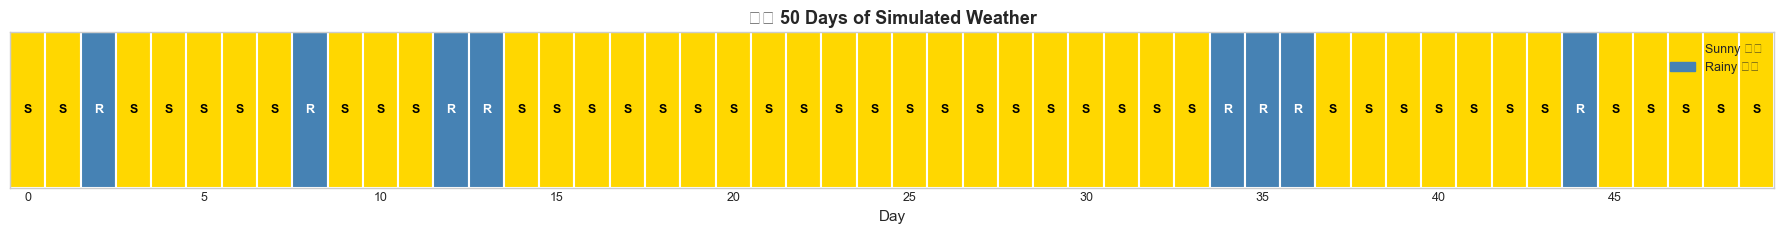


📊 MARKOV CHAIN SIMULATION RESULTS:
   Sunny days: 42/50 (84%)
   Rainy days: 8/50 (16%)

🔑 KEY INSIGHT:
   The Markov property means: tomorrow's weather depends ONLY on today!
   If sunny today → 80% sunny tomorrow, 20% rainy tomorrow
   If rainy today → 40% sunny tomorrow, 60% rainy tomorrow


In [90]:
# Simulate a Markov Chain

def simulate_markov_chain(transition_matrix, n_steps, initial_state=0):
    """Simulate a Markov Chain for n_steps."""
    n_states = transition_matrix.shape[0]
    states = [initial_state]
    current = initial_state
    
    for _ in range(n_steps - 1):
        next_state = np.random.choice(n_states, p=transition_matrix[current])
        states.append(next_state)
    
    return np.array(states)

# Simulate 50 days of weather
np.random.seed(42)
weather_sequence = simulate_markov_chain(A_weather, n_steps=50, initial_state=0)

# ─── Weather Timeline Visualization ───
fig, ax = plt.subplots(figsize=(18, 2.5))

T_w = len(weather_sequence)
palette_w  = {0: '#FFD700', 1: '#4682B4'}
label_w    = {0: 'S', 1: 'R'}
txt_col_w  = {0: 'black', 1: 'white'}

for t in range(T_w):
    ax.add_patch(plt.Rectangle((t, 0), 1, 1,
                 facecolor=palette_w[weather_sequence[t]],
                 edgecolor='white', linewidth=1.5))
    ax.text(t + 0.5, 0.5, label_w[weather_sequence[t]],
            ha='center', va='center', fontsize=9, fontweight='bold',
            color=txt_col_w[weather_sequence[t]])

ax.set_xlim(0, T_w)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xticks(np.arange(0.5, T_w, 5))
ax.set_xticklabels(range(0, T_w, 5), fontsize=9)
ax.set_xlabel('Day', fontsize=11)
ax.set_title('🌤️ 50 Days of Simulated Weather', fontsize=13, fontweight='bold', pad=6)

sunny_patch = mpatches.Patch(color='#FFD700', label='Sunny ☀️')
rainy_patch = mpatches.Patch(color='#4682B4', label='Rainy 🌧️')
ax.legend(handles=[sunny_patch, rainy_patch], loc='upper right',
          fontsize=9, framealpha=0.9, edgecolor='gray')

plt.tight_layout()
plt.show()

# Count state frequencies
sunny_count = np.sum(weather_sequence == 0)
rainy_count = np.sum(weather_sequence == 1)

print("\n📊 MARKOV CHAIN SIMULATION RESULTS:")
print(f"   Sunny days: {sunny_count}/50 ({sunny_count/50*100:.0f}%)")
print(f"   Rainy days: {rainy_count}/50 ({rainy_count/50*100:.0f}%)")
print(f"\n🔑 KEY INSIGHT:")
print(f"   The Markov property means: tomorrow's weather depends ONLY on today!")
print(f"   If sunny today → 80% sunny tomorrow, 20% rainy tomorrow")
print(f"   If rainy today → 40% sunny tomorrow, 60% rainy tomorrow")

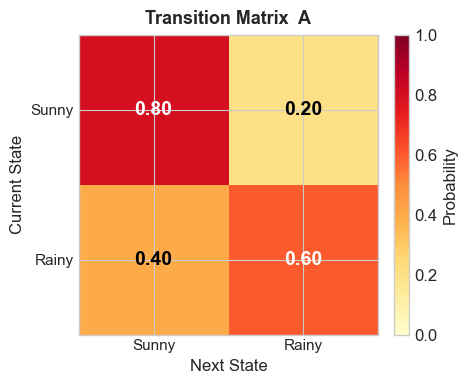

In [91]:
# ─── Transition Matrix Heatmap ───
fig, ax = plt.subplots(figsize=(5, 4))

im = ax.imshow(A_weather, cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Sunny', 'Rainy'], fontsize=11)
ax.set_yticklabels(['Sunny', 'Rainy'], fontsize=11)
ax.set_xlabel('Next State', fontsize=12)
ax.set_ylabel('Current State', fontsize=12)
ax.set_title('Transition Matrix  A', fontsize=13, fontweight='bold', pad=8)

for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{A_weather[i, j]:.2f}',
                ha='center', va='center', fontsize=14, fontweight='bold',
                color='white' if A_weather[i, j] > 0.5 else 'black')

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Probability')
plt.tight_layout()
plt.show()

### 🤔 Intuition Check — Pause and Think!

Before moving on, try to answer these questions:

1. **What would the transition matrix look like if the weather had NO temporal structure?** (i.e., today's weather tells you nothing about tomorrow's)
   <details>
   <summary>Click to reveal answer</summary>
   
   Each row would be identical! E.g., `[[0.5, 0.5], [0.5, 0.5]]` — meaning it doesn't matter what state you're in, the next state is equally random. The Markov property becomes useless here.
   </details>

2. **If `A = [[1.0, 0.0], [0.0, 1.0]]` (identity matrix), what happens?**
   <details>
   <summary>Click to reveal answer</summary>
   
   Once you enter a state, you NEVER leave it! The system is "absorbing" — the initial state determines everything forever.
   </details>

3. **What is the long-run (stationary) distribution of our weather model?** (Hint: solve πA = π)
   <details>
   <summary>Click to reveal answer</summary>
   
   The stationary distribution is π = [2/3, 1/3], meaning in the long run, ~67% of days are sunny and ~33% are rainy. Our simulation showed similar proportions!
   </details>

---

# Part 3: From Markov Chains to Hidden Markov Models 🕵️

## What Makes an HMM "Hidden"?

In a regular Markov Chain, we can **directly observe** the states (we SEE if it's sunny or rainy).

In an HMM, the states are **HIDDEN** — we can't see them directly! Instead, we observe **emissions** (outputs) that depend on the hidden state.

### The Weather & Umbrella Example 🌂

Imagine:
- You're in an **underground office** — you can't see the weather outside
- Your colleague walks in each morning — you can only see if they carry an **umbrella** or not
- You want to figure out the **weather** (hidden) from the **umbrella** (observed)

### The Three Components of an HMM

An HMM is defined by three things (often called **λ = (π, A, B)**):

1. **π (Pi) — Initial State Distribution**
   - Probability of starting in each hidden state
   - Example: P(starts Sunny) = 0.6, P(starts Rainy) = 0.4

2. **A — Transition Matrix**
   - P(next hidden state | current hidden state)
   - Same as in regular Markov Chains!

3. **B — Emission Matrix (NEW!)**
   - P(observation | hidden state)
   - Example: P(Umbrella | Rainy) = 0.9, P(Umbrella | Sunny) = 0.1

### Visual Representation

```
Hidden States:    [Sunny] ←→ [Rainy]      (governed by A)
                     ↓           ↓
Observations:   [No Umbrella] [Umbrella]   (governed by B)
```

**The key challenge: We only see the BOTTOM row!**

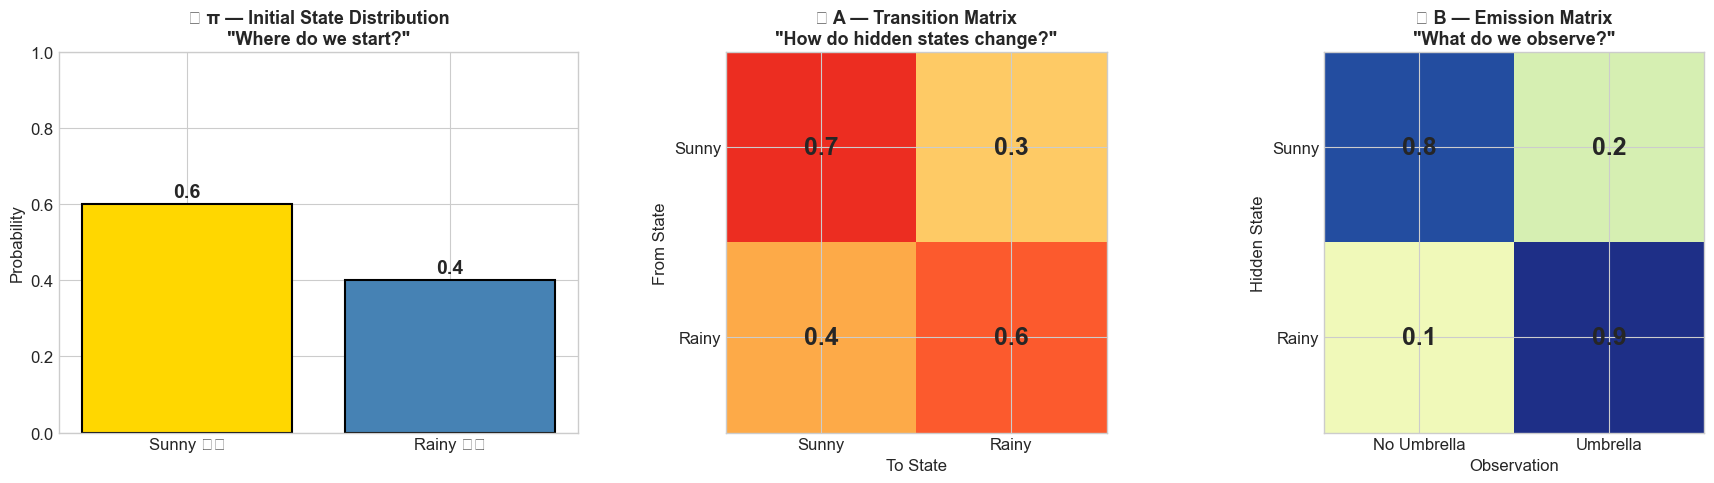


🧩 THE THREE COMPONENTS OF AN HMM:

   π (Initial Distribution):
     P(start Sunny) = 0.6, P(start Rainy) = 0.4

   A (Transition Matrix):
     P(Sunny→Sunny) = 0.7, P(Sunny→Rainy) = 0.3
     P(Rainy→Sunny) = 0.4, P(Rainy→Rainy) = 0.6

   B (Emission Matrix):
     P(No Umbrella | Sunny) = 0.8, P(Umbrella | Sunny) = 0.2
     P(No Umbrella | Rainy) = 0.1, P(Umbrella | Rainy) = 0.9

   Together: λ = (π, A, B) completely defines the HMM!


In [92]:
# Let's define our first HMM: The Weather-Umbrella Model!

# Hidden States: 0 = Sunny, 1 = Rainy
hidden_states = ['☀️ Sunny', '🌧️ Rainy']
n_hidden = 2

# Observations: 0 = No Umbrella, 1 = Umbrella
observations = ['🚶 No Umbrella', '🌂 Umbrella']
n_obs = 2

# 1. Initial State Distribution (π)
# P(starting state)
pi = np.array([0.6, 0.4])  # 60% chance starts sunny

# 2. Transition Matrix (A)
# P(next hidden state | current hidden state)
A = np.array([
    [0.7, 0.3],   # From Sunny: 70% stay sunny, 30% become rainy
    [0.4, 0.6]    # From Rainy: 40% become sunny, 60% stay rainy
])

# 3. Emission Matrix (B) - THE NEW PART!
# P(observation | hidden state)
B = np.array([
    [0.8, 0.2],   # If Sunny: 80% no umbrella, 20% umbrella
    [0.1, 0.9]    # If Rainy: 10% no umbrella, 90% umbrella
])

# Visualize all three components
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Initial Distribution (π)
bars = axes[0].bar(['Sunny ☀️', 'Rainy 🌧️'], pi, color=['gold', 'steelblue'], 
                    edgecolor='black', linewidth=1.5)
axes[0].set_ylim(0, 1)
axes[0].set_title('📊 π — Initial State Distribution\n"Where do we start?"', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Probability', fontsize=12)
for bar, val in zip(bars, pi):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{val:.1f}', ha='center', fontsize=14, fontweight='bold')

# Plot 2: Transition Matrix (A)
im1 = axes[1].imshow(A, cmap='YlOrRd', vmin=0, vmax=1)
axes[1].set_xticks([0, 1]); axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Sunny', 'Rainy'])
axes[1].set_yticklabels(['Sunny', 'Rainy'])
axes[1].set_xlabel('To State', fontsize=12)
axes[1].set_ylabel('From State', fontsize=12)
axes[1].set_title('📊 A — Transition Matrix\n"How do hidden states change?"', fontsize=13, fontweight='bold')
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, f'{A[i,j]:.1f}', ha='center', va='center', fontsize=18, fontweight='bold')

# Plot 3: Emission Matrix (B)
im2 = axes[2].imshow(B, cmap='YlGnBu', vmin=0, vmax=1)
axes[2].set_xticks([0, 1]); axes[2].set_yticks([0, 1])
axes[2].set_xticklabels(['No Umbrella', 'Umbrella'])
axes[2].set_yticklabels(['Sunny', 'Rainy'])
axes[2].set_xlabel('Observation', fontsize=12)
axes[2].set_ylabel('Hidden State', fontsize=12)
axes[2].set_title('📊 B — Emission Matrix\n"What do we observe?"', fontsize=13, fontweight='bold')
for i in range(2):
    for j in range(2):
        axes[2].text(j, i, f'{B[i,j]:.1f}', ha='center', va='center', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🧩 THE THREE COMPONENTS OF AN HMM:")
print(f"\n   π (Initial Distribution):")
print(f"     P(start Sunny) = {pi[0]:.1f}, P(start Rainy) = {pi[1]:.1f}")
print(f"\n   A (Transition Matrix):")
print(f"     P(Sunny→Sunny) = {A[0,0]:.1f}, P(Sunny→Rainy) = {A[0,1]:.1f}")
print(f"     P(Rainy→Sunny) = {A[1,0]:.1f}, P(Rainy→Rainy) = {A[1,1]:.1f}")
print(f"\n   B (Emission Matrix):")
print(f"     P(No Umbrella | Sunny) = {B[0,0]:.1f}, P(Umbrella | Sunny) = {B[0,1]:.1f}")
print(f"     P(No Umbrella | Rainy) = {B[1,0]:.1f}, P(Umbrella | Rainy) = {B[1,1]:.1f}")
print(f"\n   Together: λ = (π, A, B) completely defines the HMM!")

### 🤔 Intuition Check — Pause and Think!

1. **If the emission matrix B had IDENTICAL rows** (e.g., both Sunny and Rainy produce Umbrella 50% of the time), what would happen to decoding?
   <details>
   <summary>Click to reveal answer</summary>
   
   Observations would give us **zero information** about the hidden state! The umbrella pattern would be equally likely under any weather sequence. Decoding would be purely guessing based on transition probabilities alone. The "emission signal" is what makes HMMs useful — if B doesn't differentiate states, the hidden states are truly unrecoverable.
   </details>

2. **Could you have MORE observations than hidden states?** (e.g., 2 hidden states but 5 possible observations)
   <details>
   <summary>Click to reveal answer</summary>
   
   Absolutely! In fact, this is very common. Think of speech recognition: there might be a handful of hidden phoneme states, but hundreds of different acoustic observations. More observations can actually help distinguish states better.
   </details>

---

# Part 4: Generating Sequences — Sampling from an HMM 🎲

## How Does an HMM Generate Data?

An HMM generates a sequence step by step:

1. **Pick initial hidden state** using π
2. **Generate observation** from that state using B
3. **Transition** to next hidden state using A
4. **Repeat** steps 2-3 for each time step

Think of it like a storyteller:
- The storyteller (hidden state) changes their mood over time (transitions)
- Each mood produces different words (emissions)
- We only hear the words, not see the mood!

Let's build a function that samples from our Weather-Umbrella HMM!

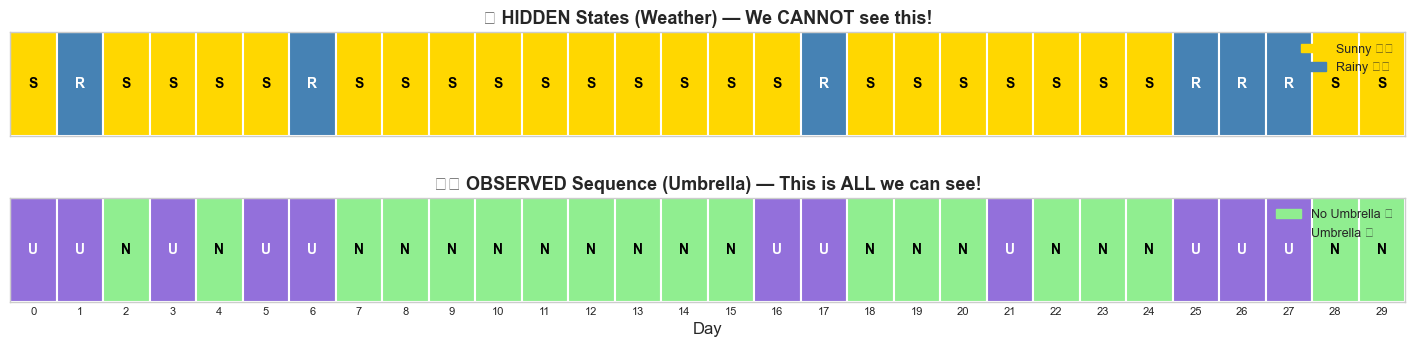


🎲 HMM SAMPLING RESULTS (30 days):
   Hidden states: ['S', 'R', 'S', 'S', 'S', 'S', 'R', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'R', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'R', 'R', 'R', 'S', 'S']
   Observations:  ['U', 'U', 'N', 'U', 'N', 'U', 'U', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'U', 'U', 'N', 'N', 'N', 'U', 'N', 'N', 'N', 'U', 'U', 'U', 'N', 'N']

🔑 KEY INSIGHT:
   The TOP row (hidden states) is UNKNOWN to us in real problems!
   We only see the BOTTOM row (observations).
   The GOAL of HMMs: Figure out the top row from the bottom row!


In [93]:
# Build an HMM sampler from scratch!

def sample_hmm(pi, A, B, n_steps):
    """
    Generate a sequence from an HMM.
    
    Parameters:
    -----------
    pi : Initial state distribution (1D array)
    A  : Transition matrix (2D array, rows sum to 1)
    B  : Emission matrix (2D array, rows sum to 1)
    n_steps : Length of sequence to generate
    
    Returns:
    --------
    hidden_states : The TRUE hidden state sequence (normally unknown!)
    observations  : The observed sequence (this is what we actually see)
    """
    n_hidden = len(pi)
    n_obs = B.shape[1]
    
    hidden_states = []
    observations = []
    
    # Step 1: Choose initial hidden state from π
    state = np.random.choice(n_hidden, p=pi)
    
    for t in range(n_steps):
        # Step 2: Generate observation from current state using B
        obs = np.random.choice(n_obs, p=B[state])
        
        hidden_states.append(state)
        observations.append(obs)
        
        # Step 3: Transition to next hidden state using A
        state = np.random.choice(n_hidden, p=A[state])
    
    return np.array(hidden_states), np.array(observations)

# Generate a 30-day sequence
np.random.seed(42)
true_states, obs_sequence = sample_hmm(pi, A, B, n_steps=30)

# ─── Cleaner Timeline Visualization ───
T = len(true_states)
fig, axes = plt.subplots(2, 1, figsize=(18, 3.5), sharex=True,
                          gridspec_kw={'hspace': 0.6})

for ax, data, title, palette, labels in [
    (axes[0], true_states,
     '🔒 HIDDEN States (Weather) — We CANNOT see this!',
     {0: '#FFD700', 1: '#4682B4'},             # gold / steelblue
     {0: 'S', 1: 'R'}),
    (axes[1], obs_sequence,
     '👁️ OBSERVED Sequence (Umbrella) — This is ALL we can see!',
     {0: '#90EE90', 1: '#9370DB'},             # lightgreen / mediumpurple
     {0: 'N', 1: 'U'}),
]:
    for t in range(T):
        color = palette[data[t]]
        ax.add_patch(plt.Rectangle((t, 0), 1, 1, facecolor=color,
                                    edgecolor='white', linewidth=1.5))
        ax.text(t + 0.5, 0.5, labels[data[t]],
                ha='center', va='center', fontsize=10, fontweight='bold',
                color='black' if data[t] == 0 else 'white')
    ax.set_xlim(0, T)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_title(title, fontsize=13, fontweight='bold', pad=6)

# x-axis day labels
axes[1].set_xticks(np.arange(0.5, T, 1))
axes[1].set_xticklabels(range(T), fontsize=8)
axes[1].set_xlabel('Day', fontsize=12)

# Legends
sunny_p = mpatches.Patch(color='#FFD700', label='Sunny ☀️')
rainy_p = mpatches.Patch(color='#4682B4', label='Rainy 🌧️')
axes[0].legend(handles=[sunny_p, rainy_p], loc='upper right', fontsize=9,
               framealpha=0.9, edgecolor='gray')

no_umb_p = mpatches.Patch(color='#90EE90', label='No Umbrella 🚶')
umb_p    = mpatches.Patch(color='#9370DB', label='Umbrella 🌂')
axes[1].legend(handles=[no_umb_p, umb_p], loc='upper right', fontsize=9,
               framealpha=0.9, edgecolor='gray')

plt.tight_layout()
plt.show()

print("\n🎲 HMM SAMPLING RESULTS (30 days):")
print(f"   Hidden states: {['S' if s==0 else 'R' for s in true_states]}")
print(f"   Observations:  {['N' if o==0 else 'U' for o in obs_sequence]}")
print(f"\n🔑 KEY INSIGHT:")
print(f"   The TOP row (hidden states) is UNKNOWN to us in real problems!")
print(f"   We only see the BOTTOM row (observations).")
print(f"   The GOAL of HMMs: Figure out the top row from the bottom row!")

---

# Part 5: The Three Fundamental Problems of HMMs 🧠

Every HMM application boils down to solving one of these three problems:

## Problem 1: Evaluation (The Forward Algorithm) 📊
**Question:** Given a model λ = (π, A, B) and an observation sequence, how **likely** is this sequence?

**Analogy:** "Given that I know the weather patterns in Seattle, how likely is it that I'd see this specific umbrella pattern?"

**Use case:** Model comparison — which HMM fits the data best?

## Problem 2: Decoding (The Viterbi Algorithm) 🔍
**Question:** Given a model and observations, what is the **most likely hidden state sequence**?

**Analogy:** "Given the umbrella pattern I observed, what was the most likely weather each day?"

**Use case:** Speech recognition (find the most likely words), gene finding

## Problem 3: Learning (The Baum-Welch / EM Algorithm) 🧗
**Question:** Given observations, find the **best model parameters** (π, A, B)?

**Analogy:** "I've never been to Seattle. Just from watching umbrella patterns, can I figure out the weather transition probabilities?"

**Use case:** Training an HMM on real data when parameters are unknown

---

| Problem | Algorithm | Input | Output |
|---------|-----------|-------|--------|
| **Evaluation** | Forward | Model + Observations | P(observations \| model) |
| **Decoding** | Viterbi | Model + Observations | Best hidden state sequence |
| **Learning** | Baum-Welch | Observations | Best model parameters (π, A, B) |

Let's implement each one from scratch! 🚀

---

# Part 6: The Forward Algorithm — Scoring Sequences 📊

## How Likely is This Observation Sequence?

Given our model λ = (π, A, B) and observations O = [o₁, o₂, ..., oₜ], we want:

$$P(O | \lambda) = \text{How likely is this observation sequence under our model?}$$

### The Naive Approach (Too Slow!)
We could sum over ALL possible hidden state sequences... but with N states and T time steps, that's N^T combinations! 😱

### The Smart Approach: Forward Algorithm (Dynamic Programming!)

Define **α_t(i)** = probability of seeing observations o₁...oₜ AND being in state i at time t:

$$\alpha_t(i) = P(o_1, o_2, ..., o_t, S_t = i | \lambda)$$

**Initialization (t=1):**
$$\alpha_1(i) = \pi_i \cdot B_i(o_1)$$

**Recursion (t=2,...,T):**
$$\alpha_t(j) = \left[\sum_{i=1}^{N} \alpha_{t-1}(i) \cdot A_{ij}\right] \cdot B_j(o_t)$$

**Answer:**
$$P(O|\lambda) = \sum_{i=1}^{N} \alpha_T(i)$$

This reduces complexity from O(N^T) to O(N² · T) — a HUGE speedup!

### ✏️ Worked Example: Forward Algorithm on a 3-Step Sequence

Before running code on 30 time steps, let's **walk through by hand** with a tiny example. You should be able to verify every number with a calculator!

**Observation sequence:** O = [🌂 Umbrella, 🚶 No Umbrella, 🌂 Umbrella] → [1, 0, 1]

Using our model: π = [0.6, 0.4], A = [[0.7, 0.3], [0.4, 0.6]], B = [[0.8, 0.2], [0.1, 0.9]]

---

**Step 1: Initialization (t=0, observe Umbrella)**

| | Sunny (i=0) | Rainy (i=1) |
|---|---|---|
| α₀(i) = π(i) × B(i, Umbrella) | 0.6 × 0.2 = **0.12** | 0.4 × 0.9 = **0.36** |

*Rainy is more likely — makes sense, we saw an umbrella!*

---

**Step 2: Recursion (t=1, observe No Umbrella)**

α₁(Sunny) = [α₀(Sunny) × A(S→S) + α₀(Rainy) × A(R→S)] × B(Sunny, NoUmb)
= [0.12 × 0.7 + 0.36 × 0.4] × 0.8 = [0.084 + 0.144] × 0.8 = 0.228 × 0.8 = **0.1824**

α₁(Rainy) = [α₀(Sunny) × A(S→R) + α₀(Rainy) × A(R→R)] × B(Rainy, NoUmb)
= [0.12 × 0.3 + 0.36 × 0.6] × 0.1 = [0.036 + 0.216] × 0.1 = 0.252 × 0.1 = **0.0252**

*Sunny now dominates — No Umbrella shifted our belief!*

---

**Step 3: Recursion (t=2, observe Umbrella)**

α₂(Sunny) = [0.1824 × 0.7 + 0.0252 × 0.4] × 0.2 = [0.12768 + 0.01008] × 0.2 = **0.02755**

α₂(Rainy) = [0.1824 × 0.3 + 0.0252 × 0.6] × 0.9 = [0.05472 + 0.01512] × 0.9 = **0.06286**

---

**Final Answer:**

P(O | λ) = α₂(Sunny) + α₂(Rainy) = 0.02755 + 0.06286 = **0.09041**

*Now let's verify this with code! 👇*

In [94]:
# ✅ Verify our hand-worked example!
tiny_obs = np.array([1, 0, 1])  # Umbrella, No Umbrella, Umbrella
alpha_tiny, log_prob_tiny = forward_algorithm(pi, A, B, tiny_obs)

print("✏️ HAND-WORKED EXAMPLE VERIFICATION:")
print(f"   Observations: [Umbrella, No Umbrella, Umbrella]\n")
print(f"   t=0: α(Sunny)={alpha_tiny[0,0]:.4f}, α(Rainy)={alpha_tiny[0,1]:.4f}  ← matches 0.12, 0.36!")
print(f"   t=1: α(Sunny)={alpha_tiny[1,0]:.4f}, α(Rainy)={alpha_tiny[1,1]:.4f}  ← matches 0.1824, 0.0252!")
print(f"   t=2: α(Sunny)={alpha_tiny[2,0]:.5f}, α(Rainy)={alpha_tiny[2,1]:.5f}")
print(f"\n   P(O|λ) = {np.sum(alpha_tiny[-1]):.5f}")
print(f"   Log P(O|λ) = {log_prob_tiny:.4f}")
print(f"\n   ✅ Numbers match our hand calculation! Now you understand the Forward Algorithm.")

✏️ HAND-WORKED EXAMPLE VERIFICATION:
   Observations: [Umbrella, No Umbrella, Umbrella]

   t=0: α(Sunny)=0.1200, α(Rainy)=0.3600  ← matches 0.12, 0.36!
   t=1: α(Sunny)=0.1824, α(Rainy)=0.0252  ← matches 0.1824, 0.0252!
   t=2: α(Sunny)=0.02755, α(Rainy)=0.06286

   P(O|λ) = 0.09041
   Log P(O|λ) = -2.4034

   ✅ Numbers match our hand calculation! Now you understand the Forward Algorithm.


📊 FORWARD ALGORITHM RESULTS:
   Observation sequence length: 30
   Log-likelihood: -20.2239
   Probability: 1.65e-09


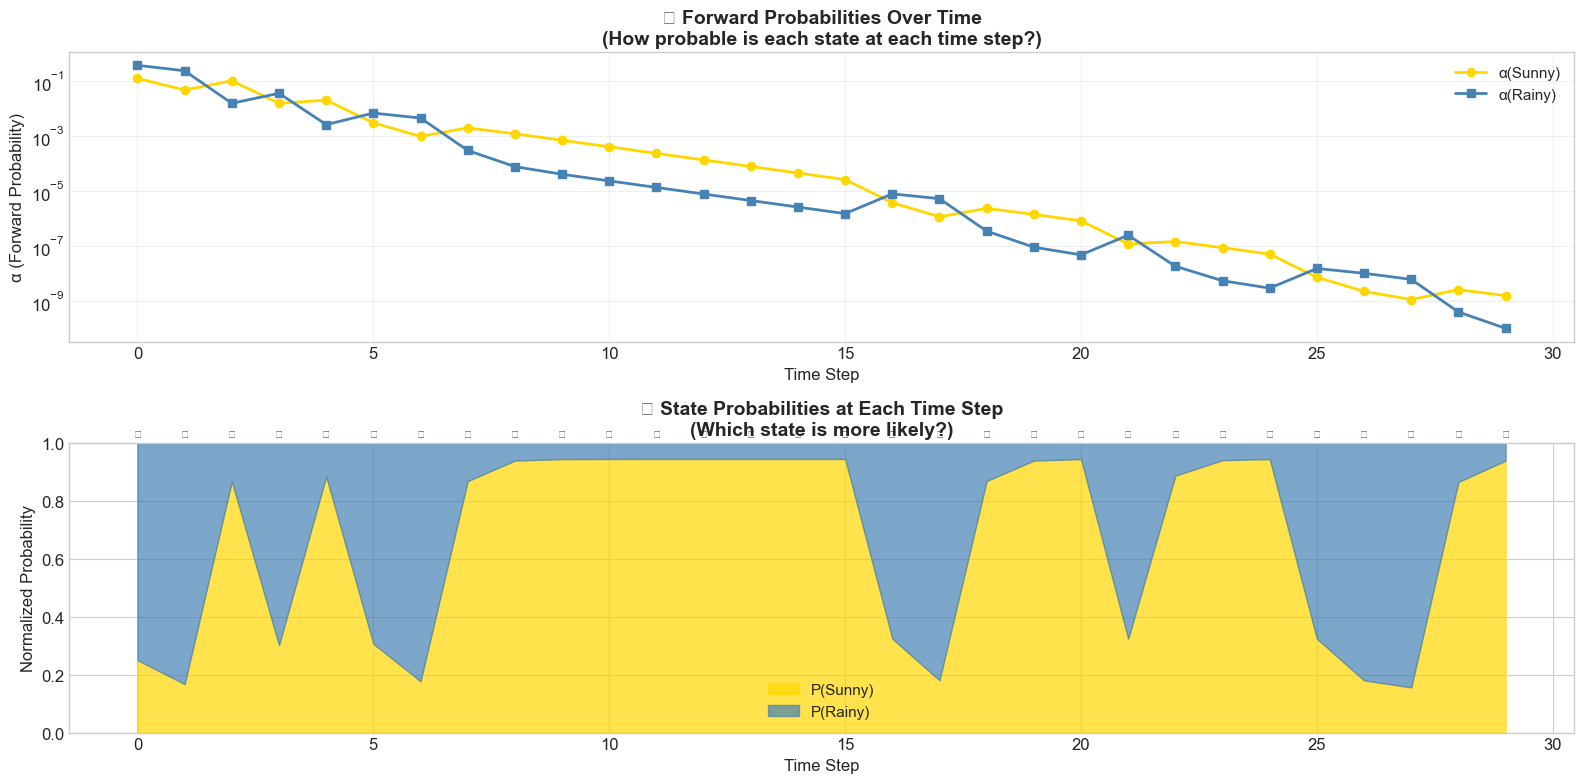


🔑 KEY INSIGHT:
   The Forward Algorithm tells us: 'How likely is this observation sequence?'
   This is used for MODEL COMPARISON — try different models, pick the one
   that gives the highest likelihood for your data!


In [95]:
# Implement the Forward Algorithm from scratch!

def forward_algorithm(pi, A, B, observations):
    """
    Compute the probability of an observation sequence using the Forward Algorithm.
    
    Parameters:
    -----------
    pi : Initial state distribution (N,)
    A  : Transition matrix (N, N)
    B  : Emission matrix (N, M)
    observations : Observation sequence (T,) — integers
    
    Returns:
    --------
    alpha : Forward probabilities (T, N) — alpha[t][i] = P(o1..ot, St=i)
    log_prob : Log probability of the observation sequence
    """
    N = len(pi)          # Number of hidden states
    T = len(observations)  # Length of sequence
    
    # Alpha table: alpha[t][i] = P(o1...ot, St=i | lambda)
    alpha = np.zeros((T, N))
    
    # STEP 1: Initialization (t=0)
    # alpha_0(i) = pi(i) * B(i, o_0)
    alpha[0] = pi * B[:, observations[0]]
    
    # STEP 2: Recursion (t=1,...,T-1)
    for t in range(1, T):
        for j in range(N):
            # Sum over all previous states
            alpha[t, j] = np.sum(alpha[t-1] * A[:, j]) * B[j, observations[t]]
    
    # STEP 3: Total probability = sum of all final alphas
    total_prob = np.sum(alpha[-1])
    log_prob = np.log(total_prob + 1e-300)  # Add tiny number to avoid log(0)
    
    return alpha, log_prob

# Test on our weather-umbrella example!
# Use the observation sequence we generated earlier
alpha, log_prob = forward_algorithm(pi, A, B, obs_sequence)

print("📊 FORWARD ALGORITHM RESULTS:")
print(f"   Observation sequence length: {len(obs_sequence)}")
print(f"   Log-likelihood: {log_prob:.4f}")
print(f"   Probability: {np.exp(log_prob):.2e}")

# Visualize the alpha values over time
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Top: Alpha values for each state over time
axes[0].plot(range(len(obs_sequence)), alpha[:, 0], 'o-', color='gold', 
             linewidth=2, markersize=6, label='α(Sunny)')
axes[0].plot(range(len(obs_sequence)), alpha[:, 1], 's-', color='steelblue', 
             linewidth=2, markersize=6, label='α(Rainy)')
axes[0].set_xlabel('Time Step', fontsize=12)
axes[0].set_ylabel('α (Forward Probability)', fontsize=12)
axes[0].set_title('📈 Forward Probabilities Over Time\n(How probable is each state at each time step?)', 
                   fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Bottom: Normalized — which state is more likely at each time?
alpha_normalized = alpha / alpha.sum(axis=1, keepdims=True)
axes[1].fill_between(range(len(obs_sequence)), 0, alpha_normalized[:, 0], 
                      color='gold', alpha=0.7, label='P(Sunny)')
axes[1].fill_between(range(len(obs_sequence)), alpha_normalized[:, 0], 1, 
                      color='steelblue', alpha=0.7, label='P(Rainy)')
axes[1].set_xlabel('Time Step', fontsize=12)
axes[1].set_ylabel('Normalized Probability', fontsize=12)
axes[1].set_title('📊 State Probabilities at Each Time Step\n(Which state is more likely?)', 
                   fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].set_ylim(0, 1)

# Mark observations on top
for t in range(len(obs_sequence)):
    marker = '🌂' if obs_sequence[t] == 1 else '🚶'
    axes[1].text(t, 1.02, marker, ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\n🔑 KEY INSIGHT:")
print(f"   The Forward Algorithm tells us: 'How likely is this observation sequence?'")
print(f"   This is used for MODEL COMPARISON — try different models, pick the one")
print(f"   that gives the highest likelihood for your data!")

### 🤔 Intuition Check — Forward Algorithm

**Why does Forward use SUM while Viterbi (next section) uses MAX?**

Think about it before reading the answer:
<details>
<summary>Click to reveal answer</summary>

They answer **different questions**:
- **Forward (SUM)**: "What is the **total probability** of seeing this observation sequence?" — we need to account for ALL possible hidden state paths, so we sum over them.
- **Viterbi (MAX)**: "What is the **single best** hidden state path?" — we only care about the most likely path, so we take the max.

**Analogy**: Imagine you want to get from city A to city B.
- Forward = "What is the total traffic flow across ALL routes?" (sum)
- Viterbi = "What is the single FASTEST route?" (max)
</details>

---

# Part 7: The Viterbi Algorithm — Finding Hidden States! 🔍

## The Most Likely Hidden State Sequence

Given observations, what's the **single best** sequence of hidden states?

**Analogy:** "Given the umbrella pattern [U, U, N, N, U], what's the most likely weather sequence?"

### How Viterbi Works (Dynamic Programming!)

Similar to Forward, but uses **max** instead of **sum**:

Define **δ_t(i)** = probability of the most likely path ending in state i at time t

**Initialization:**
$$\delta_1(i) = \pi_i \cdot B_i(o_1)$$

**Recursion:**
$$\delta_t(j) = \max_{i} [\delta_{t-1}(i) \cdot A_{ij}] \cdot B_j(o_t)$$

**Backtracking:**
$$\psi_t(j) = \arg\max_{i} [\delta_{t-1}(i) \cdot A_{ij}]$$

We store the **best predecessor** at each step, then trace back to find the full path!

### Forward vs Viterbi

| Forward Algorithm | Viterbi Algorithm |
|-------------------|-------------------|
| Uses **SUM** over all paths | Uses **MAX** over all paths |
| Gives total **probability** | Gives **best single path** |
| "How likely is the sequence?" | "What's the best explanation?" |

### ✏️ Worked Example: Viterbi on the Same 3-Step Sequence

Let's trace Viterbi on O = [Umbrella, No Umbrella, Umbrella] — same sequence, but now using **MAX** instead of SUM.

---

**Step 1: Initialization (t=0, observe Umbrella)** — *same as Forward!*

| | Sunny (i=0) | Rainy (i=1) |
|---|---|---|
| δ₀(i) = π(i) × B(i, Umbrella) | 0.6 × 0.2 = **0.12** | 0.4 × 0.9 = **0.36** |

---

**Step 2: Recursion (t=1, observe No Umbrella)** — *now using MAX!*

δ₁(Sunny) = **max**(δ₀(S) × A(S→S), δ₀(R) × A(R→S)) × B(S, NoUmb)
= max(0.12 × 0.7, 0.36 × 0.4) × 0.8 = max(0.084, 0.144) × 0.8 = **0.144 × 0.8 = 0.1152**
ψ₁(Sunny) = **Rainy** ← the max came from Rainy!

δ₁(Rainy) = max(0.12 × 0.3, 0.36 × 0.6) × 0.1 = max(0.036, 0.216) × 0.1 = **0.216 × 0.1 = 0.0216**
ψ₁(Rainy) = **Rainy**

---

**Step 3: Recursion (t=2, observe Umbrella)**

δ₂(Sunny) = max(0.1152 × 0.7, 0.0216 × 0.4) × 0.2 = max(0.08064, 0.00864) × 0.2 = **0.01613**
δ₂(Rainy) = max(0.1152 × 0.3, 0.0216 × 0.6) × 0.9 = max(0.03456, 0.01296) × 0.9 = **0.03110**

---

**Backtrack:** Best final state = Rainy (0.03110 > 0.01613) → ψ₂ = Sunny → ψ₁ = Rainy

**Best path: [Rainy, Sunny, Rainy]** → It rained, then sun, then rain. Makes sense with [☂, 🚶, ☂]!

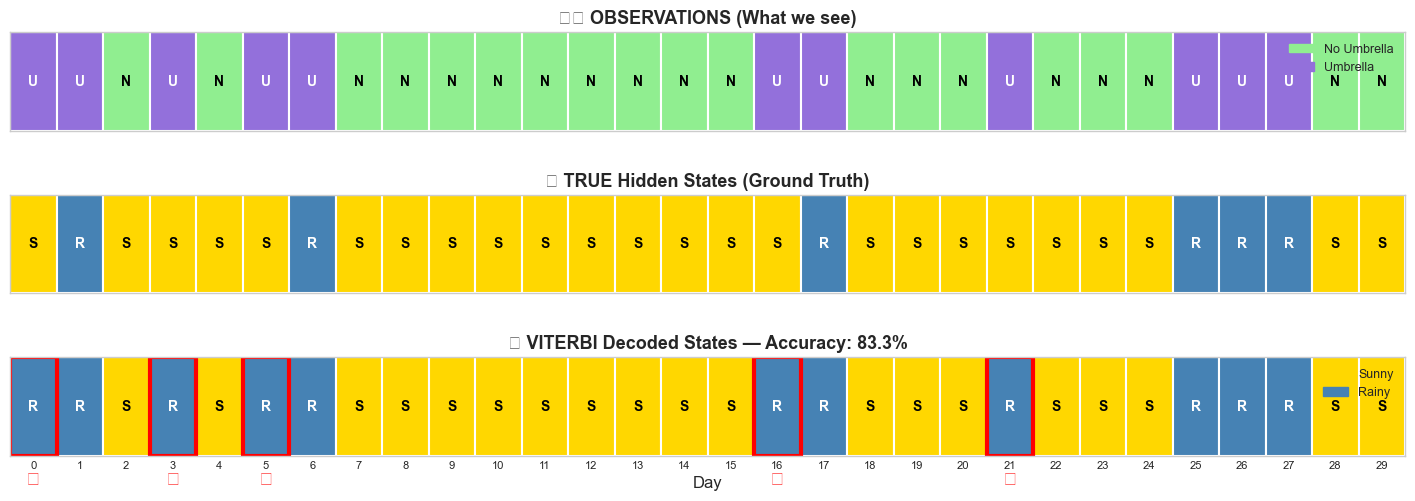


🔍 VITERBI DECODING RESULTS:
   Sequence length: 30
   Correct predictions: 25/30
   Accuracy: 83.3%

   ✗ / red borders show where Viterbi got it wrong

🔑 KEY INSIGHT:
   Even though we NEVER saw the hidden states, Viterbi found them
   with 83.3% accuracy just from the observations!


In [96]:
# Implement the Viterbi Algorithm from scratch!

def viterbi_algorithm(pi, A, B, observations):
    """
    Find the most likely hidden state sequence using the Viterbi Algorithm.
    
    Parameters:
    -----------
    pi : Initial state distribution (N,)
    A  : Transition matrix (N, N)
    B  : Emission matrix (N, M)
    observations : Observation sequence (T,)
    
    Returns:
    --------
    best_path : Most likely hidden state sequence (T,)
    delta : Viterbi probabilities (T, N)
    """
    N = len(pi)
    T = len(observations)
    
    # Delta table: best probability of any path ending in state i at time t
    delta = np.zeros((T, N))
    # Psi table: backpointer — which state led to the best path
    psi = np.zeros((T, N), dtype=int)
    
    # STEP 1: Initialization
    delta[0] = pi * B[:, observations[0]]
    psi[0] = 0  # No predecessor at t=0
    
    # STEP 2: Recursion — use MAX instead of SUM!
    for t in range(1, T):
        for j in range(N):
            # Find the best previous state
            scores = delta[t-1] * A[:, j]
            psi[t, j] = np.argmax(scores)      # Best predecessor
            delta[t, j] = np.max(scores) * B[j, observations[t]]  # Best score
    
    # STEP 3: Backtracking — trace back the best path!
    best_path = np.zeros(T, dtype=int)
    best_path[-1] = np.argmax(delta[-1])  # Start from the best final state
    
    for t in range(T-2, -1, -1):
        best_path[t] = psi[t+1, best_path[t+1]]
    
    return best_path, delta

# Decode our observation sequence!
predicted_states, delta = viterbi_algorithm(pi, A, B, obs_sequence)

# Compare with true states
accuracy = np.mean(predicted_states == true_states) * 100

# ─── Cleaner Timeline Visualization ───
T_len = len(obs_sequence)
fig, axes = plt.subplots(3, 1, figsize=(18, 5.5), sharex=True,
                          gridspec_kw={'hspace': 0.65})

row_configs = [
    (obs_sequence,
     '👁️ OBSERVATIONS (What we see)',
     {0: '#90EE90', 1: '#9370DB'},
     {0: 'N', 1: 'U'},
     {0: 'black', 1: 'white'}),
    (true_states,
     '🔒 TRUE Hidden States (Ground Truth)',
     {0: '#FFD700', 1: '#4682B4'},
     {0: 'S', 1: 'R'},
     {0: 'black', 1: 'white'}),
    (predicted_states,
     f'🔍 VITERBI Decoded States — Accuracy: {accuracy:.1f}%',
     {0: '#FFD700', 1: '#4682B4'},
     {0: 'S', 1: 'R'},
     {0: 'black', 1: 'white'}),
]

for idx, (data, title, palette, labels, text_colors) in enumerate(row_configs):
    ax = axes[idx]
    for t in range(T_len):
        color = palette[data[t]]
        ax.add_patch(plt.Rectangle((t, 0), 1, 1, facecolor=color,
                                    edgecolor='white', linewidth=1.5))
        ax.text(t + 0.5, 0.5, labels[data[t]],
                ha='center', va='center', fontsize=10, fontweight='bold',
                color=text_colors[data[t]])
    ax.set_xlim(0, T_len)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_title(title, fontsize=13, fontweight='bold', pad=6)

# Mark errors on the Viterbi row
for t in range(T_len):
    if predicted_states[t] != true_states[t]:
        axes[2].add_patch(plt.Rectangle((t, 0), 1, 1, facecolor='none',
                                         edgecolor='red', linewidth=3))
        axes[2].text(t + 0.5, -0.25, '✗', ha='center', va='center',
                     fontsize=14, color='red', fontweight='bold')

# x-axis day labels
axes[2].set_xticks(np.arange(0.5, T_len, 1))
axes[2].set_xticklabels(range(T_len), fontsize=8)
axes[2].set_xlabel('Day', fontsize=12)

# Legends
no_umb = mpatches.Patch(color='#90EE90', label='No Umbrella')
umb    = mpatches.Patch(color='#9370DB', label='Umbrella')
axes[0].legend(handles=[no_umb, umb], loc='upper right', fontsize=9,
               framealpha=0.9, edgecolor='gray')

sunny_p = mpatches.Patch(color='#FFD700', label='Sunny')
rainy_p = mpatches.Patch(color='#4682B4', label='Rainy')
axes[2].legend(handles=[sunny_p, rainy_p], loc='upper right', fontsize=9,
               framealpha=0.9, edgecolor='gray')

plt.tight_layout()
plt.show()

print(f"\n🔍 VITERBI DECODING RESULTS:")
print(f"   Sequence length: {len(obs_sequence)}")
print(f"   Correct predictions: {np.sum(predicted_states == true_states)}/{len(true_states)}")
print(f"   Accuracy: {accuracy:.1f}%")
print(f"\n   ✗ / red borders show where Viterbi got it wrong")
print(f"\n🔑 KEY INSIGHT:")
print(f"   Even though we NEVER saw the hidden states, Viterbi found them")
print(f"   with {accuracy:.1f}% accuracy just from the observations!")

### 📝 Student Exercise 1: Decode a New Sequence

**Your turn!** Use the `viterbi_algorithm` function to decode this new observation sequence and interpret the result.

Try to predict the answer BEFORE running the code:
- `[0, 0, 0, 0, 0]` → Five days of No Umbrella — what weather do you expect?
- `[1, 1, 1, 1, 1]` → Five days of Umbrella — what weather do you expect?
- `[0, 0, 1, 1, 0]` → Mixed pattern — can you spot the regime change?

In [97]:
# 📝 TODO: Student Exercise 1 — Decode these sequences!
# Uncomment and fill in the code below.

# Sequence 1: Five sunny days?
# path_1, _ = viterbi_algorithm(pi, A, B, np.array([0, 0, 0, 0, 0]))
# print("Sequence [N,N,N,N,N]:", ['Sunny' if s==0 else 'Rainy' for s in path_1])

# Sequence 2: Five rainy days?
# path_2, _ = viterbi_algorithm(pi, A, B, np.array([1, 1, 1, 1, 1]))
# print("Sequence [U,U,U,U,U]:", ['Sunny' if s==0 else 'Rainy' for s in path_2])

# Sequence 3: Regime change?
# path_3, _ = viterbi_algorithm(pi, A, B, np.array([0, 0, 1, 1, 0]))
# print("Sequence [N,N,U,U,N]:", ['Sunny' if s==0 else 'Rainy' for s in path_3])

# 🤔 Were your predictions correct? Did the regime change show up where you expected?
print("👆 Uncomment the code above and run this cell!")

👆 Uncomment the code above and run this cell!


---

# Part 8: The Baum-Welch Algorithm (EM) — Learning Parameters! 🧗

## The Hardest Problem: Learning from Data

What if we **don't know** the model parameters (π, A, B)?

We only have observations, and we need to **learn** the best parameters!

### The Expectation-Maximization (EM) Approach

The Baum-Welch algorithm uses EM:
1. **E-step**: Estimate how likely each hidden state is at each time (using Forward-Backward)
2. **M-step**: Update π, A, B based on these estimates
3. **Repeat** until convergence!

### The Backward Algorithm (needed for E-step)

Define **β_t(i)** = probability of seeing future observations o_{t+1}...o_T given state i at time t:

$$\beta_T(i) = 1 \quad \text{(initialization)}$$
$$\beta_t(i) = \sum_{j=1}^{N} A_{ij} \cdot B_j(o_{t+1}) \cdot \beta_{t+1}(j)$$

### Key Quantities

**γ_t(i)** = probability of being in state i at time t:
$$\gamma_t(i) = \frac{\alpha_t(i) \cdot \beta_t(i)}{\sum_j \alpha_t(j) \cdot \beta_t(j)}$$

**ξ_t(i,j)** = probability of transitioning from state i to j at time t:
$$\xi_t(i,j) = \frac{\alpha_t(i) \cdot A_{ij} \cdot B_j(o_{t+1}) \cdot \beta_{t+1}(j)}{\sum_{i}\sum_{j} \alpha_t(i) \cdot A_{ij} \cdot B_j(o_{t+1}) \cdot \beta_{t+1}(j)}$$

In [98]:
# Implement the Baum-Welch Algorithm from scratch!

def backward_algorithm(A, B, observations):
    """Compute backward probabilities β."""
    N = A.shape[0]
    T = len(observations)
    beta = np.zeros((T, N))
    
    # Initialization: β_T(i) = 1
    beta[-1] = 1.0
    
    # Recursion (backwards)
    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t, i] = np.sum(A[i, :] * B[:, observations[t+1]] * beta[t+1])
    
    return beta


def baum_welch(observations, n_states, n_obs, n_iterations=100, verbose=True):
    """
    Learn HMM parameters from observations using the Baum-Welch (EM) Algorithm.
    
    Parameters:
    -----------
    observations : Observation sequence (T,)
    n_states : Number of hidden states
    n_obs : Number of possible observations
    n_iterations : Maximum EM iterations
    verbose : Whether to print progress
    
    Returns:
    --------
    pi_learned, A_learned, B_learned : Learned HMM parameters
    log_likelihoods : Log-likelihood at each iteration (to track convergence)
    """
    T = len(observations)
    
    # Initialize parameters RANDOMLY (we don't know the true values!)
    np.random.seed(123)  # Different seed to show learning works
    pi_learned = np.random.dirichlet(np.ones(n_states))
    A_learned = np.array([np.random.dirichlet(np.ones(n_states)) for _ in range(n_states)])
    B_learned = np.array([np.random.dirichlet(np.ones(n_obs)) for _ in range(n_states)])
    
    log_likelihoods = []
    
    if verbose:
        print("🚀 Starting Baum-Welch Training!")
        print(f"   Random initialization — parameters are far from truth\n")
    
    for iteration in range(n_iterations):
        # ============ E-STEP ============
        # Compute forward and backward probabilities
        alpha, log_prob = forward_algorithm(pi_learned, A_learned, B_learned, observations)
        beta = backward_algorithm(A_learned, B_learned, observations)
        log_likelihoods.append(log_prob)
        
        # Compute gamma: P(state i at time t | observations)
        gamma = alpha * beta
        gamma = gamma / (gamma.sum(axis=1, keepdims=True) + 1e-300)
        
        # Compute xi: P(state i at t, state j at t+1 | observations)
        xi = np.zeros((T-1, n_states, n_states))
        for t in range(T-1):
            for i in range(n_states):
                for j in range(n_states):
                    xi[t, i, j] = (alpha[t, i] * A_learned[i, j] * 
                                   B_learned[j, observations[t+1]] * beta[t+1, j])
            xi[t] /= (xi[t].sum() + 1e-300)
        
        # ============ M-STEP ============
        # Update π: initial state distribution
        pi_learned = gamma[0]
        
        # Update A: transition matrix
        for i in range(n_states):
            for j in range(n_states):
                A_learned[i, j] = xi[:, i, j].sum() / (gamma[:-1, i].sum() + 1e-300)
        
        # Update B: emission matrix
        for i in range(n_states):
            for k in range(n_obs):
                mask = (observations == k)
                B_learned[i, k] = gamma[mask, i].sum() / (gamma[:, i].sum() + 1e-300)
        
        # Print progress
        if verbose and (iteration + 1) in [1, 5, 10, 25, 50, n_iterations]:
            print(f"   Iteration {iteration+1:>3}: Log-Likelihood = {log_prob:.4f}")
        
        # Check convergence
        if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < 1e-6:
            if verbose:
                print(f"\n   ✅ Converged at iteration {iteration+1}!")
            break
    
    return pi_learned, A_learned, B_learned, log_likelihoods


# Generate a LONGER sequence for better learning
np.random.seed(42)
true_states_long, obs_long = sample_hmm(pi, A, B, n_steps=500)

# Learn HMM parameters from ONLY the observations!
pi_learned, A_learned, B_learned, log_likelihoods = baum_welch(
    obs_long, n_states=2, n_obs=2, n_iterations=100
)

🚀 Starting Baum-Welch Training!
   Random initialization — parameters are far from truth

   Iteration   1: Log-Likelihood = -375.4478
   Iteration   5: Log-Likelihood = -347.0300
   Iteration  10: Log-Likelihood = -346.7268
   Iteration   5: Log-Likelihood = -347.0300
   Iteration  10: Log-Likelihood = -346.7268
   Iteration  25: Log-Likelihood = -346.5304
   Iteration  50: Log-Likelihood = -346.5100
   Iteration  25: Log-Likelihood = -346.5304
   Iteration  50: Log-Likelihood = -346.5100

   ✅ Converged at iteration 80!

   ✅ Converged at iteration 80!


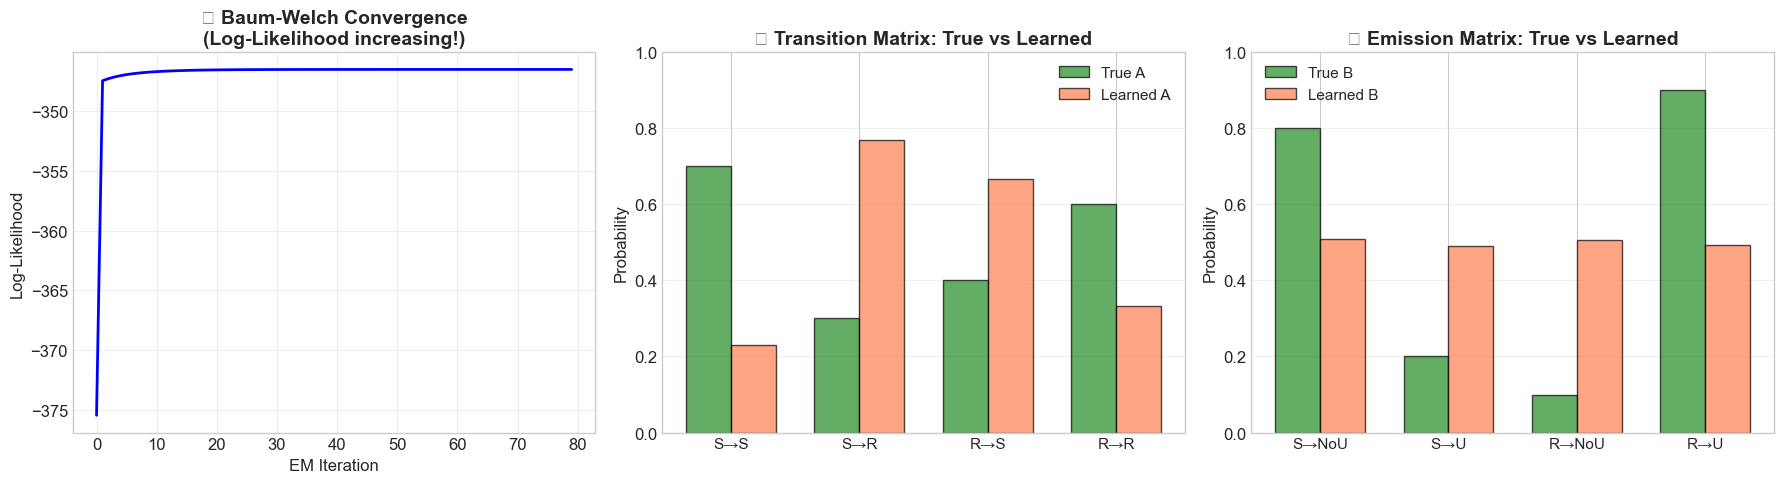


🧗 BAUM-WELCH LEARNING RESULTS:

   True π: [0.6 0.4]
   Learned π: [0.372 0.628]

   True A (Transition Matrix):
   [[0.7 0.3]
 [0.4 0.6]]
   Learned A:
   [[0.23  0.77 ]
 [0.667 0.333]]

   True B (Emission Matrix):
   [[0.8 0.2]
 [0.1 0.9]]
   Learned B:
   [[0.509 0.491]
 [0.507 0.493]]

🔑 KEY INSIGHT:
   Starting from RANDOM parameters, Baum-Welch recovered values
   close to the true parameters — just from the observations!
   ⚠️ Note: States may be SWAPPED (label switching) — that's normal!


In [99]:
# Visualize Baum-Welch convergence and compare learned vs true parameters

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Log-likelihood convergence
axes[0].plot(log_likelihoods, 'b-', linewidth=2)
axes[0].set_xlabel('EM Iteration', fontsize=12)
axes[0].set_ylabel('Log-Likelihood', fontsize=12)
axes[0].set_title('📈 Baum-Welch Convergence\n(Log-Likelihood increasing!)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: True vs Learned Transition Matrix
comparison_A = np.vstack([A.flatten(), A_learned.flatten()]).T
x_labels = ['S→S', 'S→R', 'R→S', 'R→R']
x_pos = np.arange(len(x_labels))
width = 0.35
bars1 = axes[1].bar(x_pos - width/2, A.flatten(), width, label='True A', color='forestgreen', alpha=0.7, edgecolor='black')
bars2 = axes[1].bar(x_pos + width/2, A_learned.flatten(), width, label='Learned A', color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels, fontsize=11)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title('📊 Transition Matrix: True vs Learned', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: True vs Learned Emission Matrix
x_labels_B = ['S→NoU', 'S→U', 'R→NoU', 'R→U']
bars3 = axes[2].bar(x_pos - width/2, B.flatten(), width, label='True B', color='forestgreen', alpha=0.7, edgecolor='black')
bars4 = axes[2].bar(x_pos + width/2, B_learned.flatten(), width, label='Learned B', color='coral', alpha=0.7, edgecolor='black')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(x_labels_B, fontsize=11)
axes[2].set_ylabel('Probability', fontsize=12)
axes[2].set_title('📊 Emission Matrix: True vs Learned', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].set_ylim(0, 1)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n🧗 BAUM-WELCH LEARNING RESULTS:")
print(f"\n   True π: {pi}")
print(f"   Learned π: {np.round(pi_learned, 3)}")
print(f"\n   True A (Transition Matrix):")
print(f"   {A}")
print(f"   Learned A:")
print(f"   {np.round(A_learned, 3)}")
print(f"\n   True B (Emission Matrix):")
print(f"   {B}")
print(f"   Learned B:")
print(f"   {np.round(B_learned, 3)}")
print(f"\n🔑 KEY INSIGHT:")
print(f"   Starting from RANDOM parameters, Baum-Welch recovered values")
print(f"   close to the true parameters — just from the observations!")
print(f"   ⚠️ Note: States may be SWAPPED (label switching) — that's normal!")

### 📝 Student Exercise 2: How Much Data Does Baum-Welch Need?

Try training Baum-Welch on sequences of different lengths and observe how the learned parameters compare to the truth. What's the minimum sequence length for reasonable accuracy?

In [100]:
# 📝 TODO: Student Exercise 2 — Experiment with data size!
# Uncomment and run to see how Baum-Welch performs with different amounts of data.

# for n in [20, 50, 100, 200, 500, 1000]:
#     np.random.seed(42)
#     _, obs_test = sample_hmm(pi, A, B, n_steps=n)
#     pi_test, A_test, B_test, _ = baum_welch(obs_test, n_states=2, n_obs=2, n_iterations=100, verbose=False)
#     # Compare learned A to true A (using Frobenius norm)
#     error = np.linalg.norm(A - A_test, 'fro')
#     print(f"   n={n:>5}: A error = {error:.4f}  {'✅ Good!' if error < 0.1 else '⚠️ Needs more data'}")

# 🤔 At what sequence length does the error become acceptably small?
print("👆 Uncomment the code above and run this cell!")

👆 Uncomment the code above and run this cell!


---

### ⚠️ Why Log-Probabilities Matter: The Numerical Underflow Problem

The cheat sheet mentions using log-probabilities. But *why*? Let's see the problem firsthand. When we multiply many small probabilities together (as the Forward algorithm does), the numbers shrink toward zero **exponentially fast**. At some point, floating-point numbers can't represent them anymore — they become exactly `0.0`. This is called **numerical underflow**, and it silently destroys your results.

In [101]:
# ⚠️ DEMONSTRATION: Numerical underflow in the Forward Algorithm
# Let's run Forward on increasingly long sequences and watch α values collapse to 0

print("⚠️ NUMERICAL UNDERFLOW DEMONSTRATION")
print("=" * 65)
print(f"\n{'Seq Length':<15} {'max(α)':<20} {'min(α)':<20} {'Status'}")
print("-" * 65)

np.random.seed(42)
for length in [10, 30, 50, 100, 200, 500, 1000]:
    _, test_obs = sample_hmm(pi, A, B, n_steps=length)
    alpha_test, log_prob_test = forward_algorithm(pi, A, B, test_obs)
    max_alpha = np.max(alpha_test[-1])
    min_alpha = np.min(alpha_test[-1])
    
    if max_alpha == 0:
        status = "💀 UNDERFLOW! All zeros!"
    elif max_alpha < 1e-300:
        status = "🔴 Dangerously small"
    elif max_alpha < 1e-100:
        status = "🟡 Getting tiny"
    else:
        status = "🟢 OK"
    
    print(f"T = {length:<10} {max_alpha:<20.2e} {min_alpha:<20.2e} {status}")

print(f"\n💀 PROBLEM: For long sequences, α values become EXACTLY ZERO!")
print(f"   This means P(O|λ) = 0, which is WRONG — it should just be very small.")
print(f"\n✅ SOLUTION: Work in LOG SPACE!")
print(f"   Instead of multiplying tiny probabilities, ADD log-probabilities.")
print(f"   log(a × b) = log(a) + log(b) — addition never underflows!")
print(f"\n   This is why hmmlearn works in log-space internally,")
print(f"   and why we added log_prob to our forward_algorithm function.")

⚠️ NUMERICAL UNDERFLOW DEMONSTRATION

Seq Length      max(α)               min(α)               Status
-----------------------------------------------------------------
T = 10         6.78e-04             3.95e-05             🟢 OK
T = 30         6.81e-10             2.95e-10             🟢 OK
T = 50         1.57e-15             1.98e-16             🟢 OK
T = 100        4.30e-30             2.76e-31             🟢 OK
T = 200        1.84e-60             2.78e-61             🟢 OK
T = 500        4.27e-147            9.39e-148            🟡 Getting tiny
T = 1000       1.15e-298            2.46e-299            🟡 Getting tiny

💀 PROBLEM: For long sequences, α values become EXACTLY ZERO!
   This means P(O|λ) = 0, which is WRONG — it should just be very small.

✅ SOLUTION: Work in LOG SPACE!
   Instead of multiplying tiny probabilities, ADD log-probabilities.
   log(a × b) = log(a) + log(b) — addition never underflows!

   This is why hmmlearn works in log-space internally,
   and why we added log_

---

### 🔴 When Things Go Wrong: HMM Failure Cases

Everything has worked beautifully so far — but that's unrealistic! In practice, HMMs can fail in several ways. Understanding failures is just as important as understanding successes. Let's see three common pitfalls.

In [102]:
# 🔴 FAILURE CASE DEMONSTRATIONS

# ── Failure 1: Poor Initialization → Local Optimum ──
print("🔴 FAILURE 1: Poor Initialization (Local Optimum)")
print("=" * 55)
print("   Running Baum-Welch 5 times with different random seeds...\n")

np.random.seed(42)
_, obs_fail = sample_hmm(pi, A, B, n_steps=200)

final_lls = []
for seed in [0, 7, 13, 42, 99]:
    np.random.seed(seed)
    pi_init = np.random.dirichlet(np.ones(2))
    A_init = np.array([np.random.dirichlet(np.ones(2)) for _ in range(2)])
    B_init = np.array([np.random.dirichlet(np.ones(2)) for _ in range(2)])
    
    # Run a few EM iterations manually
    for _ in range(50):
        alpha_f, ll = forward_algorithm(pi_init, A_init, B_init, obs_fail)
        beta_f = backward_algorithm(A_init, B_init, obs_fail)
        gamma_f = alpha_f * beta_f
        gamma_f = gamma_f / (gamma_f.sum(axis=1, keepdims=True) + 1e-300)
        
        xi_f = np.zeros((len(obs_fail)-1, 2, 2))
        for t in range(len(obs_fail)-1):
            for i in range(2):
                for j in range(2):
                    xi_f[t,i,j] = alpha_f[t,i]*A_init[i,j]*B_init[j,obs_fail[t+1]]*beta_f[t+1,j]
            xi_f[t] /= (xi_f[t].sum() + 1e-300)
        
        pi_init = gamma_f[0]
        for i in range(2):
            for j in range(2):
                A_init[i,j] = xi_f[:,i,j].sum() / (gamma_f[:-1,i].sum() + 1e-300)
            for k in range(2):
                A_init[i] /= A_init[i].sum()
                B_init[i,k] = gamma_f[obs_fail==k,i].sum() / (gamma_f[:,i].sum() + 1e-300)
    
    _, final_ll = forward_algorithm(pi_init, A_init, B_init, obs_fail)
    final_lls.append(final_ll)
    marker = "⭐ BEST" if final_ll == max(final_lls) else ""
    print(f"   Seed {seed:>2}: Final Log-Likelihood = {final_ll:.4f}  {marker}")

print(f"\n   ⚠️ Different seeds → different final log-likelihoods!")
print(f"   The gap between best and worst: {max(final_lls) - min(final_lls):.4f}")
print(f"   → Always run multiple initializations and pick the best!\n")

# ── Failure 2: Wrong Number of States ──
print("\n🔴 FAILURE 2: Wrong Number of Hidden States")
print("=" * 55)
print("   True model has 2 states. What if we use 5?\n")

np.random.seed(42)
_, obs_wrong_k = sample_hmm(pi, A, B, n_steps=300)
pi_5, A_5, B_5, ll_5 = baum_welch(obs_wrong_k, n_states=5, n_obs=2, n_iterations=50, verbose=False)
print(f"   Learned transition matrix (5 states):")
print(f"   {np.round(A_5, 2)}")
print(f"\n   ⚠️ Notice: Some rows look nearly identical → the model is")
print(f"   over-splitting states that should be one. Extra states are")
print(f"   'wasted' with near-zero initial probability or duplicate behavior.")
print(f"   This is why AIC/BIC model selection is essential!\n")

# ── Failure 3: Too Little Data ──
print("\n🔴 FAILURE 3: Too Little Data")
print("=" * 55)
np.random.seed(42)
_, obs_tiny = sample_hmm(pi, A, B, n_steps=15)
pi_tiny, A_tiny, B_tiny, _ = baum_welch(obs_tiny, n_states=2, n_obs=2, n_iterations=100, verbose=False)
print(f"   Only 15 observations!")
print(f"   True A:    {A.flatten().round(2)}")
print(f"   Learned A: {A_tiny.flatten().round(2)}")
error_tiny = np.linalg.norm(A - A_tiny, 'fro')
print(f"   Error (Frobenius norm): {error_tiny:.4f}")
print(f"\n   ⚠️ With only 15 data points, Baum-Welch can't reliably learn.")
print(f"   The learned parameters may be far from the truth!")
print(f"   Rule of thumb: Need at least 50-100× more data than parameters.")

🔴 FAILURE 1: Poor Initialization (Local Optimum)
   Running Baum-Welch 5 times with different random seeds...

   Seed  0: Final Log-Likelihood = -136.9070  ⭐ BEST
   Seed  7: Final Log-Likelihood = -138.4464  
   Seed 13: Final Log-Likelihood = -138.4697  
   Seed 42: Final Log-Likelihood = -136.8172  ⭐ BEST
   Seed 13: Final Log-Likelihood = -138.4697  
   Seed 42: Final Log-Likelihood = -136.8172  ⭐ BEST
   Seed 99: Final Log-Likelihood = -137.8348  

   ⚠️ Different seeds → different final log-likelihoods!
   The gap between best and worst: 1.6525
   → Always run multiple initializations and pick the best!


🔴 FAILURE 2: Wrong Number of Hidden States
   True model has 2 states. What if we use 5?

   Seed 99: Final Log-Likelihood = -137.8348  

   ⚠️ Different seeds → different final log-likelihoods!
   The gap between best and worst: 1.6525
   → Always run multiple initializations and pick the best!


🔴 FAILURE 2: Wrong Number of Hidden States
   True model has 2 states. What if we

---

# Part 9: Using hmmlearn — Sklearn-Style API! 🚀

## From Scratch to Production

We've built everything from scratch to **understand** how HMMs work. Now let's use `hmmlearn` — a library with a scikit-learn-like API that's:
- ✅ **Faster** (optimized C code under the hood)
- ✅ **Handles edge cases** (numerical stability, scaling)
- ✅ **Supports Gaussian emissions** (continuous observations!)
- ✅ **Model selection** (AIC/BIC for choosing number of states)

### 🌉 Bridging Discrete → Continuous Emissions

So far, our emission matrix **B** was a simple lookup table: `B[state, observation]` = probability of that discrete observation in that state.

But real-world data is usually **continuous** (temperature, stock returns, sensor readings). How does this change things?

**The key insight: Almost NOTHING changes!** The three algorithms (Forward, Viterbi, Baum-Welch) work exactly the same way. The only difference:

| | Discrete Emissions | Continuous (Gaussian) Emissions |
|---|---|---|
| **B** | A matrix: `B[i, o]` = P(obs=o \| state=i) | A PDF: `b_i(x) = N(x; μ_i, Σ_i)` |
| **Lookup** | Simple table lookup | Evaluate Gaussian PDF at observation x |
| **Parameters** | Probability values per symbol | Mean (μ) and Covariance (Σ) per state |
| **Forward/Viterbi** | Multiply by `B[j, o_t]` | Multiply by `N(o_t; μ_j, Σ_j)` |
| **M-step** | Count observation frequencies | Compute weighted mean and covariance |

**That's it!** Everything else — α recursion, δ recursion, backtracking, ξ, γ — stays identical. This is the beauty of the HMM framework.

### Install hmmlearn
```python
pip install hmmlearn
```

✅ hmmlearn is installed!

📊 Generated synthetic continuous dataset:
   Samples: 800
   Features: 2
   Hidden states: 3


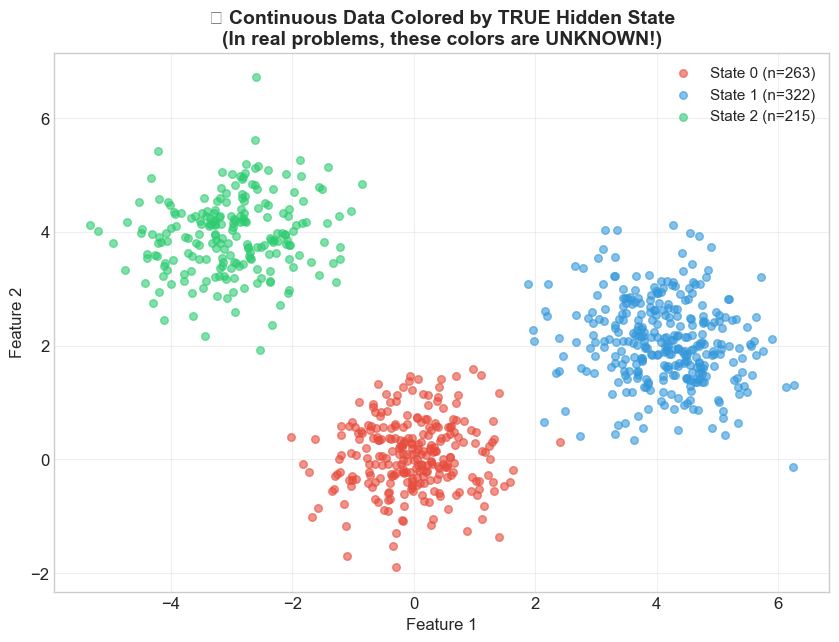

In [103]:
# Using hmmlearn — the sklearn-style HMM library!

try:
    from hmmlearn import hmm
    print("✅ hmmlearn is installed!")
except ImportError:
    print("❌ hmmlearn not found. Install with: pip install hmmlearn")

# ============================================
# Step 1: Create a synthetic CONTINUOUS dataset
# ============================================
# Ground truth: 3 hidden states with 2D Gaussian emissions
np.random.seed(42)

n_states_true = 3
true_means = np.array([[0.0, 0.0],    # State 0: centered at origin
                        [4.0, 2.0],    # State 1: upper right
                        [-3.0, 4.0]])  # State 2: upper left

true_covars = np.array([[[0.5, 0.05], [0.05, 0.4]],   # State 0: tight cluster
                         [[0.7, -0.1], [-0.1, 0.6]],   # State 1: medium spread
                         [[0.6, 0.0],  [0.0, 0.5]]])    # State 2: medium spread

true_transmat = np.array([[0.7, 0.2, 0.1],
                           [0.1, 0.8, 0.1],
                           [0.2, 0.1, 0.7]])

true_startprob = np.array([0.6, 0.3, 0.1])

# Sample from this HMM manually
def sample_gaussian_hmm(startprob, transmat, means, covars, n_samples=500):
    """Sample from a Gaussian HMM."""
    states = []
    observations = []
    state = np.random.choice(len(startprob), p=startprob)
    
    for _ in range(n_samples):
        states.append(state)
        obs = np.random.multivariate_normal(means[state], covars[state])
        observations.append(obs)
        state = np.random.choice(len(startprob), p=transmat[state])
    
    return np.array(observations), np.array(states)

X_continuous, y_true_states = sample_gaussian_hmm(
    true_startprob, true_transmat, true_means, true_covars, n_samples=800
)

print(f"\n📊 Generated synthetic continuous dataset:")
print(f"   Samples: {X_continuous.shape[0]}")
print(f"   Features: {X_continuous.shape[1]}")
print(f"   Hidden states: {n_states_true}")

# Visualize the data colored by TRUE hidden state
plt.figure(figsize=(10, 7))
colors = ['#e74c3c', '#3498db', '#2ecc71']
state_labels = ['State 0', 'State 1', 'State 2']

for s in range(n_states_true):
    mask = (y_true_states == s)
    plt.scatter(X_continuous[mask, 0], X_continuous[mask, 1], 
                s=30, c=colors[s], alpha=0.6, label=f'{state_labels[s]} (n={mask.sum()})')

plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('🎨 Continuous Data Colored by TRUE Hidden State\n(In real problems, these colors are UNKNOWN!)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

In [104]:
# ============================================
# Step 2: Fit a GaussianHMM using hmmlearn
# ============================================

model = hmm.GaussianHMM(
    n_components=3,           # Number of hidden states
    covariance_type='full',   # Full covariance matrices
    n_iter=200,               # Max EM iterations
    random_state=42,
    verbose=False
)

# Fit the model (just like sklearn: model.fit(X))
model.fit(X_continuous)

print("✅ GaussianHMM trained!")
print(f"\n📊 LEARNED PARAMETERS:")
print(f"\n   Learned start probabilities: {np.round(model.startprob_, 3)}")
print(f"   True start probabilities:    {true_startprob}")
print(f"\n   Learned transition matrix:")
print(f"   {np.round(model.transmat_, 3)}")
print(f"\n   True transition matrix:")
print(f"   {true_transmat}")
print(f"\n   Learned means:")
for i, m in enumerate(model.means_):
    print(f"   State {i}: [{m[0]:.2f}, {m[1]:.2f}]")
print(f"\n   True means:")
for i, m in enumerate(true_means):
    print(f"   State {i}: [{m[0]:.2f}, {m[1]:.2f}]")

✅ GaussianHMM trained!

📊 LEARNED PARAMETERS:

   Learned start probabilities: [0. 0. 1.]
   True start probabilities:    [0.6 0.3 0.1]

   Learned transition matrix:
   [[0.    1.    0.   ]
 [0.75  0.002 0.248]
 [0.143 0.132 0.725]]

   True transition matrix:
   [[0.7 0.2 0.1]
 [0.1 0.8 0.1]
 [0.2 0.1 0.7]]

   Learned means:
   State 0: [1.46, 2.80]
   State 1: [1.09, 2.82]
   State 2: [-0.02, 0.05]

   True means:
   State 0: [0.00, 0.00]
   State 1: [4.00, 2.00]
   State 2: [-3.00, 4.00]


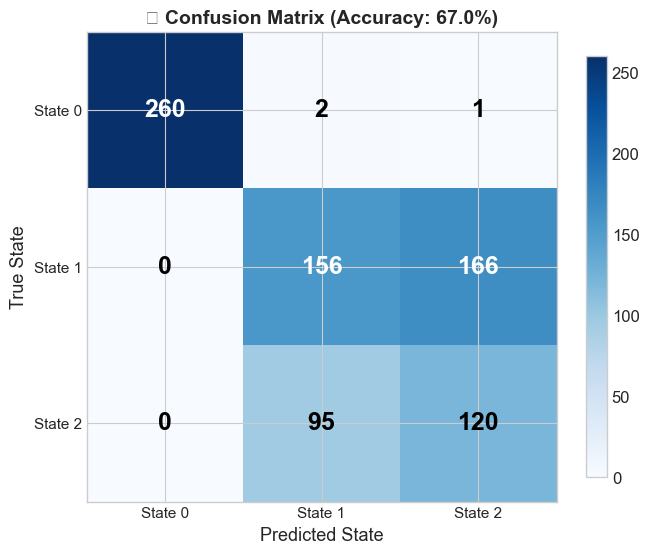


🎯 Decoding Results:
   Accuracy (after label alignment): 67.0%

💡 INSIGHT: Most errors occur between states with similar means/covariances.
   The diagonal dominance shows the HMM learned the structure well!


In [105]:
# ============================================
# Step 3: Decode & Evaluate — Confusion Matrix
# ============================================

# Find the most likely hidden states (Viterbi)
y_pred = model.predict(X_continuous)

# Handle label switching with Hungarian algorithm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_true_states, y_pred)
row_ind, col_ind = linear_sum_assignment(-cm)
mapping = dict(zip(col_ind, row_ind))
y_pred_mapped = np.vectorize(lambda s: mapping.get(s, s))(y_pred)

accuracy = accuracy_score(y_true_states, y_pred_mapped)
cm_aligned = confusion_matrix(y_true_states, y_pred_mapped)

# ─── Confusion Matrix Heatmap ───
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm_aligned, cmap='Blues', interpolation='nearest')

# Add text annotations
for i in range(cm_aligned.shape[0]):
    for j in range(cm_aligned.shape[1]):
        val = cm_aligned[i, j]
        color = 'white' if val > cm_aligned.max() / 2 else 'black'
        ax.text(j, i, str(val), ha='center', va='center',
                fontsize=18, fontweight='bold', color=color)

state_names = ['State 0', 'State 1', 'State 2']
ax.set_xticks(range(3)); ax.set_yticks(range(3))
ax.set_xticklabels(state_names, fontsize=11)
ax.set_yticklabels(state_names, fontsize=11)
ax.set_xlabel('Predicted State', fontsize=13)
ax.set_ylabel('True State', fontsize=13)
ax.set_title(f'📋 Confusion Matrix (Accuracy: {accuracy:.1%})',
             fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

print(f"\n🎯 Decoding Results:")
print(f"   Accuracy (after label alignment): {accuracy:.1%}")
print(f"\n💡 INSIGHT: Most errors occur between states with similar means/covariances.")
print(f"   The diagonal dominance shows the HMM learned the structure well!")

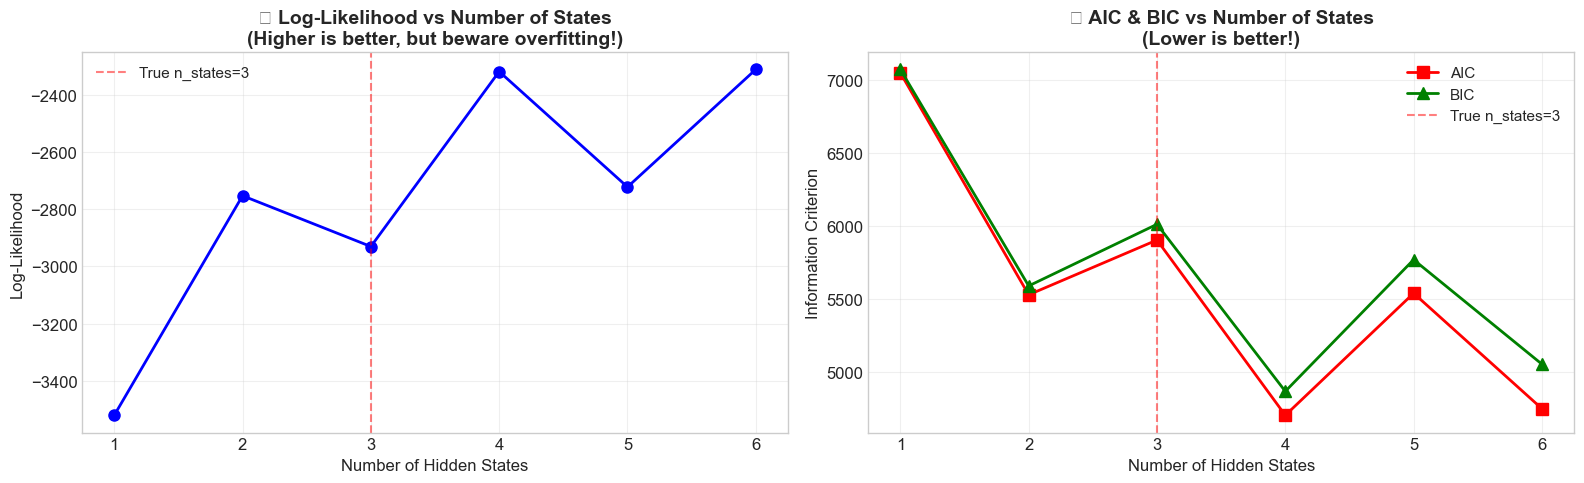


🎯 MODEL SELECTION RESULTS:

          log_likelihood  n_params          AIC          BIC
n_states                                                    
1           -3520.349045         5  7050.698090  7074.121149
2           -2752.796311        13  5531.592622  5592.492574
3           -2930.268206        23  5906.536412  6014.282482
4           -2318.484999        35  4706.969999  4870.931409
5           -2722.136269        49  5542.272538  5771.818513
6           -2311.138599        65  4752.277197  5056.776960

   Best by AIC: 4 states
   Best by BIC: 4 states
   True number:  3 states

🔑 KEY INSIGHT:
   AIC/BIC balance model fit (log-likelihood) with complexity (n_params).
   They correctly identify 3 states as optimal — matching the ground truth!


In [106]:
# ============================================
# Step 4: Model Selection — How many hidden states?
# ============================================
# We used 3 states because we knew the truth. In practice, we don't!
# Use AIC/BIC to find the optimal number of states.

def count_hmm_params(n_components, n_features, covariance_type='full'):
    """Count the number of free parameters in a GaussianHMM."""
    # Start probabilities: n_components - 1
    start_params = n_components - 1
    # Transition matrix: n_components * (n_components - 1)
    trans_params = n_components * (n_components - 1)
    # Means: n_components * n_features
    mean_params = n_components * n_features
    # Covariances
    if covariance_type == 'full':
        cov_params = n_components * n_features * (n_features + 1) // 2
    elif covariance_type == 'diag':
        cov_params = n_components * n_features
    else:
        cov_params = n_components * n_features
    return start_params + trans_params + mean_params + cov_params

results = []
for k in range(1, 7):
    m = hmm.GaussianHMM(n_components=k, covariance_type='full', n_iter=200, random_state=42)
    m.fit(X_continuous)
    log_likelihood = m.score(X_continuous)       # Total log-likelihood
    n_params = count_hmm_params(k, X_continuous.shape[1])
    n_samples = X_continuous.shape[0]
    
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(n_samples)
    
    results.append({
        'n_states': k,
        'log_likelihood': log_likelihood,
        'n_params': n_params,
        'AIC': aic,
        'BIC': bic
    })

df_results = pd.DataFrame(results).set_index('n_states')

# Plot AIC/BIC
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Log-likelihood
axes[0].plot(df_results.index, df_results['log_likelihood'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Hidden States', fontsize=12)
axes[0].set_ylabel('Log-Likelihood', fontsize=12)
axes[0].set_title('📈 Log-Likelihood vs Number of States\n(Higher is better, but beware overfitting!)', 
                   fontsize=14, fontweight='bold')
axes[0].axvline(x=3, color='red', linestyle='--', alpha=0.5, label='True n_states=3')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Right: AIC and BIC
axes[1].plot(df_results.index, df_results['AIC'], 'rs-', linewidth=2, markersize=8, label='AIC')
axes[1].plot(df_results.index, df_results['BIC'], 'g^-', linewidth=2, markersize=8, label='BIC')
axes[1].set_xlabel('Number of Hidden States', fontsize=12)
axes[1].set_ylabel('Information Criterion', fontsize=12)
axes[1].set_title('📊 AIC & BIC vs Number of States\n(Lower is better!)', 
                   fontsize=14, fontweight='bold')
axes[1].axvline(x=3, color='red', linestyle='--', alpha=0.5, label='True n_states=3')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best
best_aic = df_results['AIC'].idxmin()
best_bic = df_results['BIC'].idxmin()

print(f"\n🎯 MODEL SELECTION RESULTS:")
print(f"\n{df_results.to_string()}")
print(f"\n   Best by AIC: {best_aic} states")
print(f"   Best by BIC: {best_bic} states")
print(f"   True number:  3 states")
print(f"\n🔑 KEY INSIGHT:")
print(f"   AIC/BIC balance model fit (log-likelihood) with complexity (n_params).")
print(f"   They correctly identify 3 states as optimal — matching the ground truth!")

---

# Part 10: Real-World Application — Market Regime Detection 💹

## Using HMMs to Find Hidden Market Regimes

Stock markets often switch between different **regimes**:
- **Bull Market** 📈: Low volatility, positive returns (stable growth)
- **Bear Market** 📉: High volatility, negative returns (panic & crashes)
- **Sideways Market** ↔️: Medium volatility, near-zero returns

These regimes are **hidden** — we can't directly observe them. But we CAN observe:
- Daily stock returns
- Trading volume
- Volatility measures

This is a perfect use case for HMMs!

**Goal:** Fit an HMM to stock market data and identify the hidden market regimes.

We'll use **realistic synthetic market data** for this example (so it works without internet/API access).

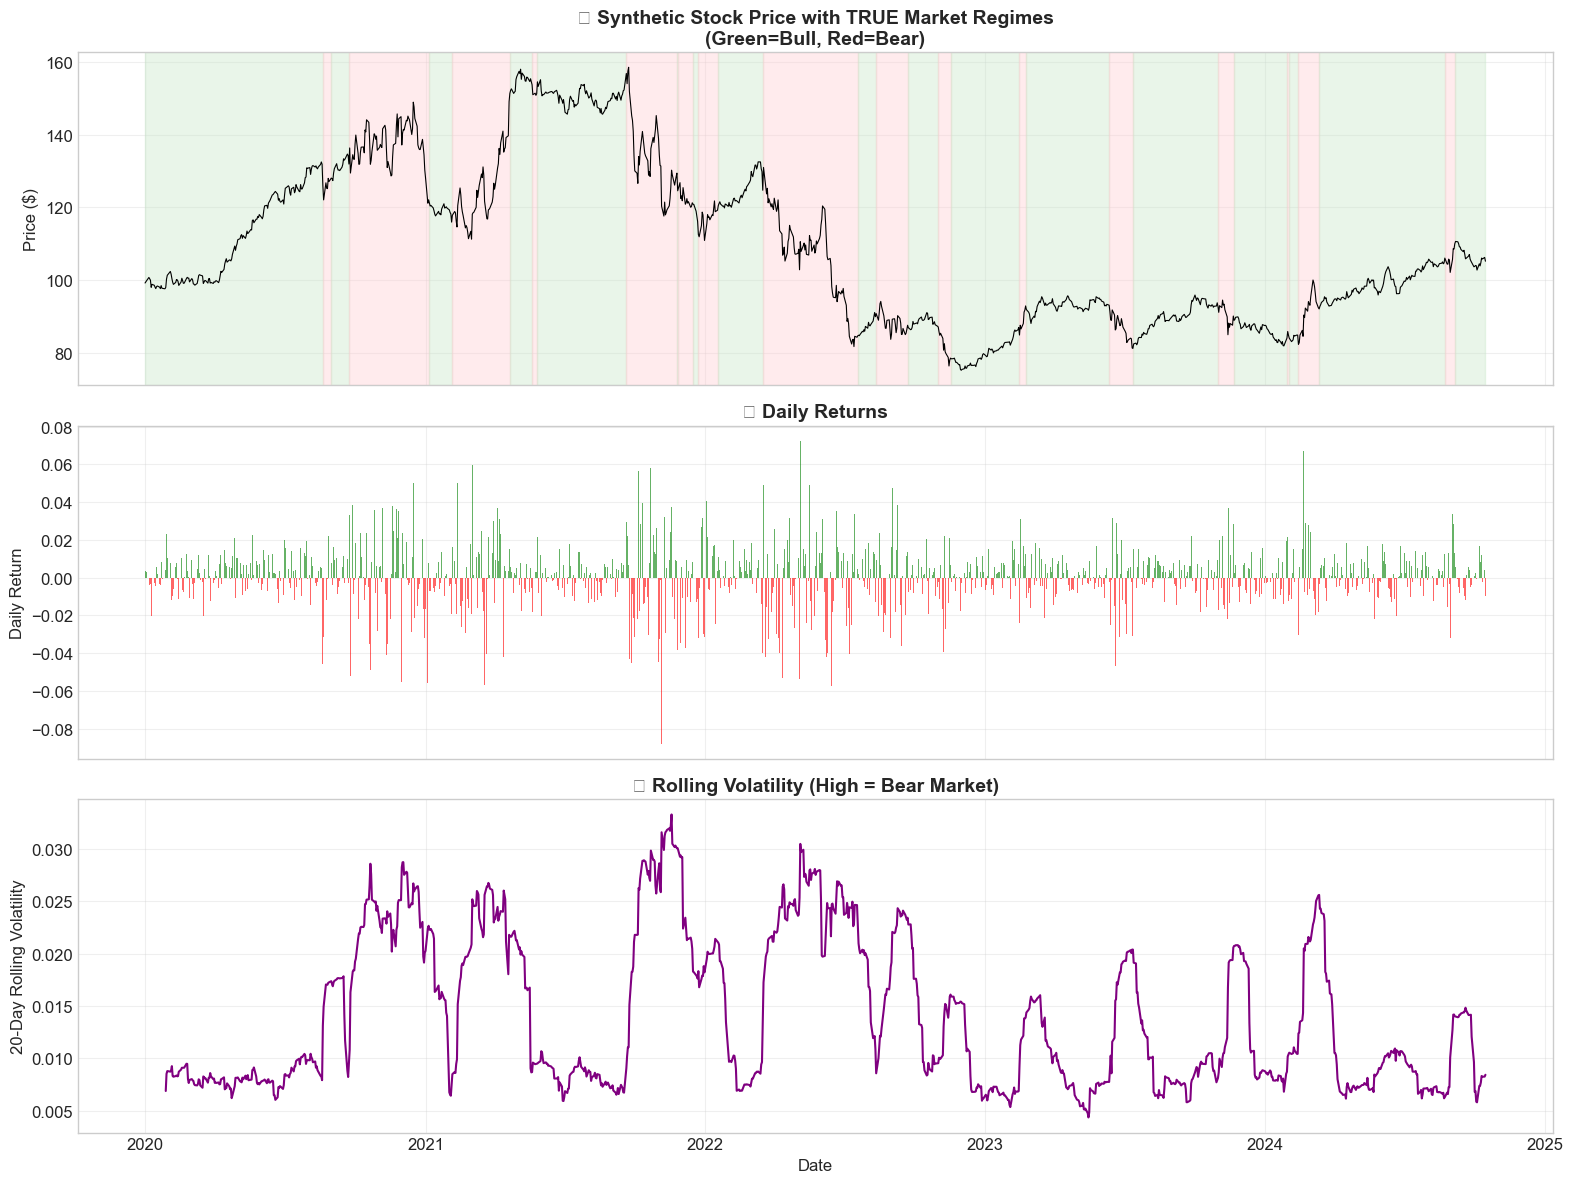


📊 MARKET DATA SUMMARY:
   Trading days: 1250
   Bull market days: 826 (66.1%)
   Bear market days: 424 (33.9%)
   Final price: $105.19 (started at $100.00)


In [107]:
# Generate realistic synthetic market data with hidden regimes

np.random.seed(42)

# Define 2 market regimes
# Regime 0: Bull Market (stable, positive returns)
# Regime 1: Bear Market (volatile, negative returns)

regime_params = {
    0: {'mean_return': 0.0008, 'volatility': 0.008, 'name': '📈 Bull (Stable)'},
    1: {'mean_return': -0.001, 'volatility': 0.025, 'name': '📉 Bear (Volatile)'}
}

# Transition probabilities between regimes
# Bull markets tend to persist, bear markets are shorter
market_trans = np.array([
    [0.98, 0.02],   # Bull → Bull: 98%, Bull → Bear: 2%
    [0.05, 0.95]    # Bear → Bull: 5%, Bear → Bear: 95%
])

market_start = np.array([0.8, 0.2])

# Generate 5 years of daily data (~1250 trading days)
n_days = 1250
market_states = []
returns = []

state = np.random.choice(2, p=market_start)
for t in range(n_days):
    market_states.append(state)
    params = regime_params[state]
    daily_return = np.random.normal(params['mean_return'], params['volatility'])
    returns.append(daily_return)
    state = np.random.choice(2, p=market_trans[state])

returns = np.array(returns)
market_states = np.array(market_states)

# Convert returns to price series (starting at $100)
prices = 100 * np.exp(np.cumsum(returns))

# Create a date index
dates = pd.date_range(start='2020-01-01', periods=n_days, freq='B')

# Create DataFrame
market_df = pd.DataFrame({
    'Date': dates,
    'Price': prices,
    'Return': returns,
    'True_Regime': market_states
})
market_df.set_index('Date', inplace=True)

# Visualize the market data
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Plot 1: Price with true regime coloring
axes[0].plot(market_df.index, market_df['Price'], 'k-', linewidth=0.8)
# Color background by true regime
start = 0
for t in range(1, n_days):
    if market_states[t] != market_states[t-1] or t == n_days - 1:
        color = '#c8e6c9' if market_states[start] == 0 else '#ffcdd2'
        axes[0].axvspan(dates[start], dates[min(t, n_days-1)], alpha=0.4, color=color)
        start = t
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].set_title('📈 Synthetic Stock Price with TRUE Market Regimes\n(Green=Bull, Red=Bear)', 
                   fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Daily Returns
axes[1].bar(market_df.index, market_df['Return'], width=1, 
            color=['green' if r >= 0 else 'red' for r in returns], alpha=0.6)
axes[1].set_ylabel('Daily Return', fontsize=12)
axes[1].set_title('📊 Daily Returns', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Rolling volatility
rolling_vol = pd.Series(returns).rolling(20).std()
axes[2].plot(dates, rolling_vol, 'purple', linewidth=1.5)
axes[2].set_ylabel('20-Day Rolling Volatility', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_title('📉 Rolling Volatility (High = Bear Market)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 MARKET DATA SUMMARY:")
print(f"   Trading days: {n_days}")
print(f"   Bull market days: {np.sum(market_states==0)} ({np.mean(market_states==0)*100:.1f}%)")
print(f"   Bear market days: {np.sum(market_states==1)} ({np.mean(market_states==1)*100:.1f}%)")
print(f"   Final price: ${prices[-1]:.2f} (started at $100.00)")

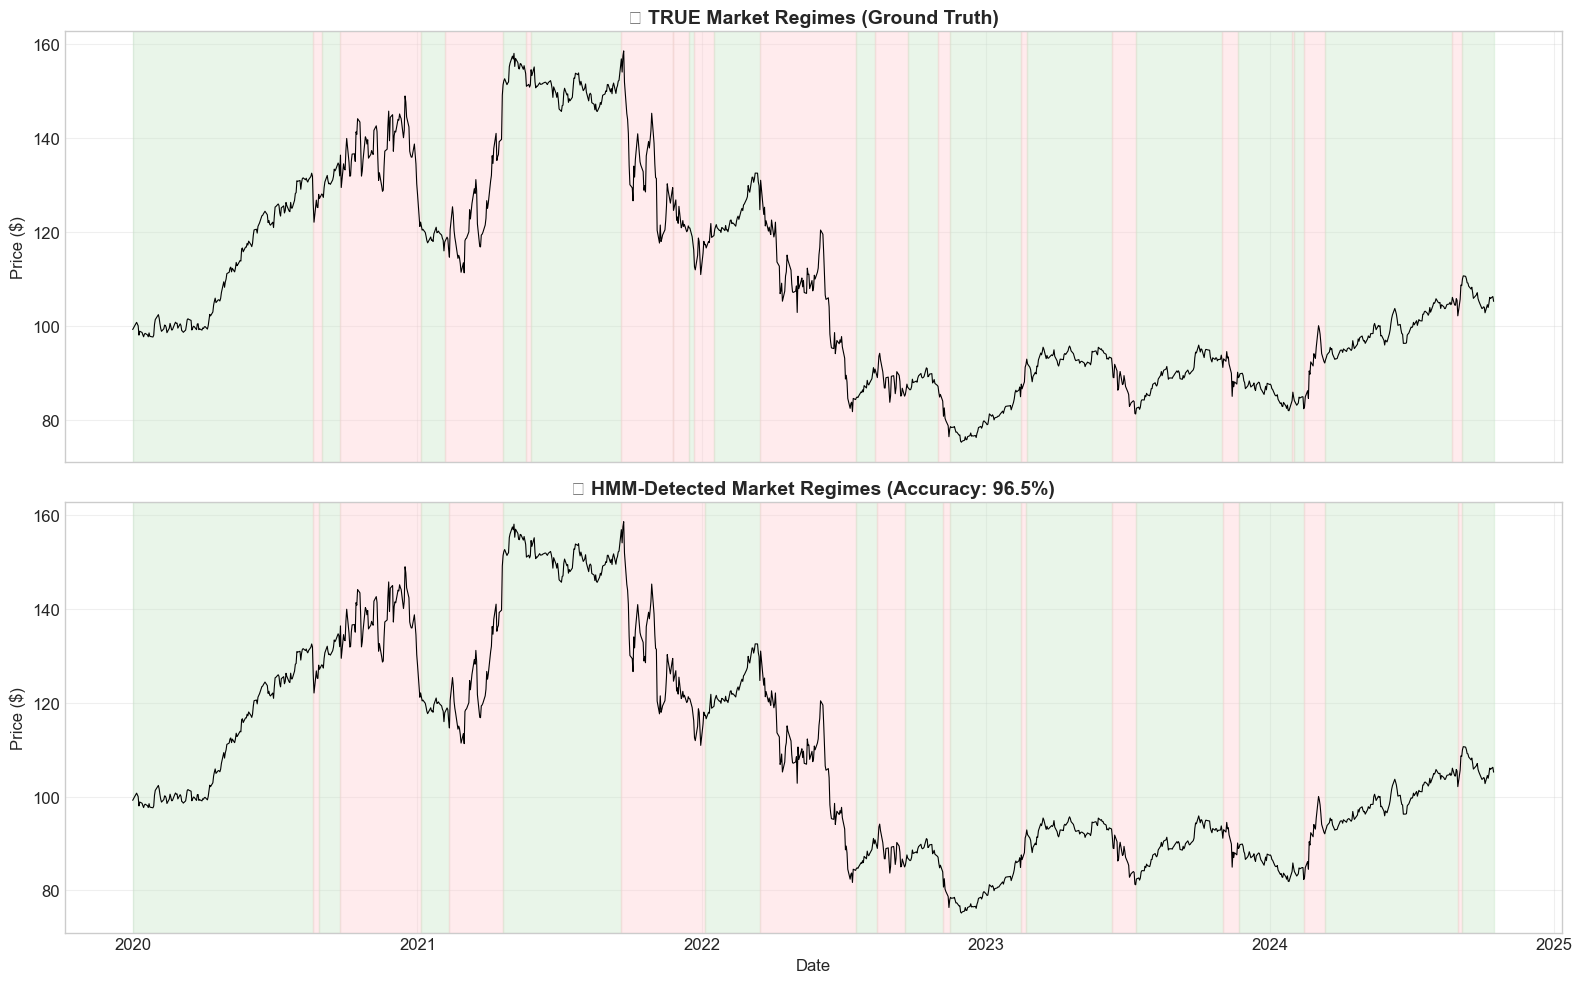


🤖 HMM MARKET REGIME DETECTION RESULTS:

📊 Learned Parameters:
   State 0 (📈 Bull):
     Mean daily return: 0.0886%
     Volatility (std):  0.8981%
   State 1 (📉 Bear):
     Mean daily return: -0.1762%
     Volatility (std):  2.5349%

📈 Transition Matrix (learned):
   [[0.98259482 0.01740518]
 [0.03702937 0.96297063]]

🎯 Regime Detection Accuracy: 96.5%

💡 INSIGHT: The HMM successfully identifies market regimes
   from returns alone — it discovers the hidden structure!
   In practice, this helps portfolio managers adjust risk.


In [108]:
# Fit a 2-state GaussianHMM to detect market regimes

from hmmlearn.hmm import GaussianHMM

# Prepare observation data (daily returns)
X_market = market_df['Return'].values.reshape(-1, 1)

# Fit HMM
market_hmm = GaussianHMM(
    n_components=2,
    covariance_type='full',
    n_iter=200,
    random_state=42
)
market_hmm.fit(X_market)

# Predict hidden states (regimes)
predicted_regimes = market_hmm.predict(X_market)

# Align labels (handle label switching)
# The HMM may assign 0 to Bear and 1 to Bull, so we check means
hmm_means = market_hmm.means_.flatten()
if hmm_means[0] > hmm_means[1]:
    # State 0 has higher mean → it's the bull market
    regime_map = {0: 0, 1: 1}  # Already aligned
else:
    # State 1 has higher mean → swap labels
    regime_map = {0: 1, 1: 0}
    
aligned_regimes = np.array([regime_map[s] for s in predicted_regimes])

# Calculate detection accuracy
accuracy = np.mean(aligned_regimes == market_states)

# Visualize HMM-detected regimes vs true regimes
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Plot 1: True regimes
axes[0].plot(dates, prices, 'k-', linewidth=0.8)
start = 0
for t in range(1, n_days):
    if market_states[t] != market_states[t-1] or t == n_days - 1:
        color = '#c8e6c9' if market_states[start] == 0 else '#ffcdd2'
        axes[0].axvspan(dates[start], dates[min(t, n_days-1)], alpha=0.4, color=color)
        start = t
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].set_title('🎯 TRUE Market Regimes (Ground Truth)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: HMM-detected regimes
axes[1].plot(dates, prices, 'k-', linewidth=0.8)
start = 0
for t in range(1, n_days):
    if aligned_regimes[t] != aligned_regimes[t-1] or t == n_days - 1:
        color = '#c8e6c9' if aligned_regimes[start] == 0 else '#ffcdd2'
        axes[1].axvspan(dates[start], dates[min(t, n_days-1)], alpha=0.4, color=color)
        start = t
axes[1].set_ylabel('Price ($)', fontsize=12)
axes[1].set_title(f'🤖 HMM-Detected Market Regimes (Accuracy: {accuracy*100:.1f}%)', 
                   fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed results
print(f"\n🤖 HMM MARKET REGIME DETECTION RESULTS:")
print(f"{'='*55}")
print(f"\n📊 Learned Parameters:")
for i in range(2):
    state_label = '📈 Bull' if regime_map.get(i, i) == 0 else '📉 Bear'
    print(f"   State {i} ({state_label}):")
    print(f"     Mean daily return: {market_hmm.means_[i][0]*100:.4f}%")
    print(f"     Volatility (std):  {np.sqrt(market_hmm.covars_[i][0][0])*100:.4f}%")
print(f"\n📈 Transition Matrix (learned):")
print(f"   {market_hmm.transmat_}")
print(f"\n🎯 Regime Detection Accuracy: {accuracy*100:.1f}%")
print(f"\n💡 INSIGHT: The HMM successfully identifies market regimes")
print(f"   from returns alone — it discovers the hidden structure!")
print(f"   In practice, this helps portfolio managers adjust risk.")

### 📝 Student Exercise 3: Try a 3-State Market Model

We used 2 states (Bull/Bear) because we knew the ground truth. But what if there's also a **Sideways market** (low volatility, near-zero returns)?

**Your task:**
1. Fit a 3-state `GaussianHMM` to `X_market`
2. Predict regimes and plot the results
3. Interpret: What does the third state represent? Does it improve the model?
4. Compare AIC/BIC for 2 vs 3 states — which is better?

In [109]:
# 📝 TODO: Student Exercise 3 — Try a 3-state market model!
# Uncomment and fill in the code below.

# market_hmm_3 = GaussianHMM(n_components=3, covariance_type='full', n_iter=200, random_state=42)
# market_hmm_3.fit(X_market)

# # What are the 3 regimes?
# for i in range(3):
#     print(f"State {i}: mean={market_hmm_3.means_[i][0]*100:.4f}%, "
#           f"vol={np.sqrt(market_hmm_3.covars_[i][0][0])*100:.4f}%")

# # Compare AIC for 2 vs 3 states
# n_params_2 = 2*(2-1) + 2*(2-1) + 2*1 + 2*1*(1+1)//2  # startprob + trans + means + covars
# n_params_3 = 3*(3-1) + 3*(3-1) + 3*1 + 3*1*(1+1)//2
# aic_2 = -2 * market_hmm.score(X_market) + 2 * n_params_2
# aic_3 = -2 * market_hmm_3.score(X_market) + 2 * n_params_3
# print(f"\nAIC (2 states): {aic_2:.2f}")
# print(f"AIC (3 states): {aic_3:.2f}")
# print(f"Better model: {'3 states' if aic_3 < aic_2 else '2 states'}")

print("👆 Uncomment the code above and run this cell!")

👆 Uncomment the code above and run this cell!


---

## Part 11: Practical Tips and When to Use HMMs 🎯

### ✅ Strengths of HMMs
| Strength | Description |
|----------|-------------|
| **Unsupervised learning** | Discovers hidden structure without labeled data |
| **Temporal modeling** | Naturally captures sequential dependencies |
| **Probabilistic** | Provides probability estimates, not just point predictions |
| **Well-studied theory** | Solid mathematical foundation with efficient algorithms |
| **Interpretable** | Parameters (π, A, B) have clear physical meaning |

### ⚠️ Limitations
| Limitation | Description |
|------------|-------------|
| **Markov assumption** | Future depends only on current state (memoryless) |
| **Fixed number of states** | Must choose K in advance (use AIC/BIC) |
| **Local optima** | EM algorithm may converge to local optima |
| **Computational cost** | O(T × K²) per iteration of Baum-Welch |
| **Emission distribution** | Must specify distribution family (Gaussian, etc.) |

### 🔍 When to Use HMMs
- **Sequential data** with regime-switching behavior
- **Speech recognition** — phoneme sequence decoding
- **Finance** — market regime detection, volatility modeling
- **Bioinformatics** — gene prediction, protein structure
- **NLP** — POS tagging, named entity recognition (classic approach)
- **Anomaly detection** — identifying unusual state transitions

### 🔄 Alternatives to Consider
| Scenario | Alternative |
|----------|-------------|
| Long-range dependencies | **LSTMs / Transformers** |
| Non-Markovian dynamics | **CRFs (Conditional Random Fields)** |
| More than 1st-order dependence | **Higher-order HMMs** |
| Continuous state space | **Kalman Filters / State Space Models** |
| Very large datasets | **Deep generative models (VAEs)** |

In [110]:
# Decision guide: When to use HMMs

print("=" * 70)
print("🎯 HMM DECISION GUIDE: SHOULD YOU USE AN HMM?")
print("=" * 70)

print("""
❓ Ask yourself these questions:

  1. Is your data SEQUENTIAL (ordered in time)?
     ├─ NO  → Consider clustering (K-Means, GMM) instead
     └─ YES → Continue ↓

  2. Do you believe there are HIDDEN STATES driving observations?
     ├─ NO  → Consider ARIMA, regression, or RNNs
     └─ YES → Continue ↓

  3. Is the MARKOV ASSUMPTION reasonable?
     (Future depends only on current state, not full history)
     ├─ NO  → Consider LSTMs, Transformers, or CRFs
     └─ YES → Continue ↓

  4. Can observations be modeled with a known DISTRIBUTION?
     (Gaussian, Multinomial, etc.)
     ├─ NO  → Consider deep generative models
     └─ YES → ✅ HMM is a great choice!

""")

print("=" * 70)
print("📋 QUICK REFERENCE: HMM HYPERPARAMETERS")
print("=" * 70)

hyperparams = [
    ("n_components", "Number of hidden states (K)", "2-10", "Use AIC/BIC for selection"),
    ("covariance_type", "Shape of emission covariance", "full/diag/tied", "'full' is most flexible"),
    ("n_iter", "Max EM iterations", "100-500", "Check convergence score"),
    ("tol", "Convergence threshold", "1e-4 to 1e-2", "Smaller = more precise"),
    ("init_params", "Which params to initialize", "'stmc'", "Use '' if providing custom init"),
    ("random_state", "Reproducibility seed", "42", "Always set for reproducibility"),
]

print(f"\n{'Parameter':<20} {'Description':<35} {'Range':<12} {'Tip'}")
print("-" * 100)
for name, desc, range_val, tip in hyperparams:
    print(f"{name:<20} {desc:<35} {range_val:<12} {tip}")

print(f"\n💡 Pro Tip: Always try multiple random initializations!")
print(f"   Run the model 5-10 times with different seeds and pick")
print(f"   the one with the highest log-likelihood (convergence score).")

🎯 HMM DECISION GUIDE: SHOULD YOU USE AN HMM?

❓ Ask yourself these questions:

  1. Is your data SEQUENTIAL (ordered in time)?
     ├─ NO  → Consider clustering (K-Means, GMM) instead
     └─ YES → Continue ↓

  2. Do you believe there are HIDDEN STATES driving observations?
     ├─ NO  → Consider ARIMA, regression, or RNNs
     └─ YES → Continue ↓

  3. Is the MARKOV ASSUMPTION reasonable?
     (Future depends only on current state, not full history)
     ├─ NO  → Consider LSTMs, Transformers, or CRFs
     └─ YES → Continue ↓

  4. Can observations be modeled with a known DISTRIBUTION?
     (Gaussian, Multinomial, etc.)
     ├─ NO  → Consider deep generative models
     └─ YES → ✅ HMM is a great choice!


📋 QUICK REFERENCE: HMM HYPERPARAMETERS

Parameter            Description                         Range        Tip
----------------------------------------------------------------------------------------------------
n_components         Number of hidden states (K)         2-10        

---

# 🎓 Summary

## You've completed the Hidden Markov Models (HMM) Guide! 🎉

### 📚 What You Learned:

| Part | Topic | Key Takeaway |
|------|-------|-------------|
| **1** | Setup & Imports | Libraries and tools for HMM analysis |
| **2** | Markov Chains | States, transitions, and the Markov property |
| **3** | HMM Components | Initial probs (π), transitions (A), emissions (B) |
| **4** | Sampling from HMMs | Generating sequences from known models |
| **5** | Three Fundamental Problems | Evaluation, Decoding, Learning |
| **6** | Forward Algorithm | P(observations \| model) — with hand-worked example |
| **7** | Viterbi Algorithm | Most likely hidden state sequence — with hand-worked example |
| **8** | Baum-Welch Algorithm | Learning parameters from data via EM |
| | ⚠️ Underflow & Failures | Why log-space matters + what goes wrong in practice |
| **9** | hmmlearn Library | Discrete → Continuous bridge + GaussianHMM + AIC/BIC |
| **10** | Market Regime Detection | Real-world application in finance |
| **11** | Practical Tips | When to use HMMs and hyperparameter guide |


### 🔑 Key Formulas:
- **Forward**: α_t(j) = [Σ_i α_{t-1}(i) × a_{ij}] × b_j(o_t)
- **Viterbi**: δ_t(j) = max_i [δ_{t-1}(i) × a_{ij}] × b_j(o_t)
- **Baum-Welch**: Iteratively updates π, A, B using forward-backward probabilities

### 🚀 Next Steps:
1. **Complete the exercises**: Go back and do the TODO cells if you haven't!
2. **Practice**: Try HMMs on speech or text data
3. **Explore**: Experiment with different numbers of hidden states
4. **Advance**: Study Conditional Random Fields (CRFs) and deep sequential models
5. **Apply**: Use HMMs for anomaly detection in your own time-series data

> *"The Markov property is not just a mathematical convenience — it's a powerful modeling assumption that makes the intractable tractable."* — Lawrence Rabiner

---

# 🧠 Hidden Markov Models — Cheat Sheet

---

## HMM Definition: λ = (π, A, B)

| Symbol | Name | Formula |
|--------|------|---------|
| **π** | Initial state distribution | P(S₁ = i) |
| **A** | Transition matrix | a_ij = P(S_t = j \| S_{t-1} = i) |
| **B** | Emission distribution | b_j(o) = P(O_t = o \| S_t = j) |

---

## Three Fundamental Problems

| # | Problem | Algorithm | Complexity |
|---|---------|-----------|------------|
| 1 | **Evaluation**: P(O \| λ) | Forward Algorithm | O(T × K²) |
| 2 | **Decoding**: S* = argmax P(S\|O,λ) | Viterbi Algorithm | O(T × K²) |
| 3 | **Learning**: λ* = argmax P(O\|λ) | Baum-Welch (EM) | O(T × K² × iter) |

---

## Key Algorithm Formulas

| Algorithm | Recurrence |
|-----------|-----------|
| **Forward** | α_t(j) = [Σᵢ α_{t-1}(i) × a_ij] × b_j(o_t) |
| **Backward** | β_t(i) = Σⱼ a_ij × b_j(o_{t+1}) × β_{t+1}(j) |
| **Viterbi** | δ_t(j) = max_i [δ_{t-1}(i) × a_ij] × b_j(o_t) |
| **Baum-Welch** | E-step → compute ξ, γ; M-step → update π, A, B |

---

## hmmlearn Quick Start

```python
from hmmlearn.hmm import GaussianHMM

model = GaussianHMM(n_components=K, covariance_type='full', n_iter=100)
model.fit(X)                    # Learn parameters
states = model.predict(X)       # Decode hidden states
score  = model.score(X)         # Log-likelihood
```

---

## Model Selection

| Criterion | Formula | Rule |
|-----------|---------|------|
| **AIC** | -2 × log(L) + 2k | Lower is better |
| **BIC** | -2 × log(L) + k × log(T) | Lower is better; penalizes complexity more |

> *k = number of free parameters, T = number of observations*

---

## Golden Rules

1. ✅ Always set `random_state` for reproducibility
2. 🔄 Try multiple initializations — EM finds **local** optima
3. 📉 Use **log-probabilities** to avoid numerical underflow
4. 📈 Check convergence: monitor `model.score()` across iterations
5. 🧠 Validate with **domain knowledge** — states should be interpretable
6. 📏 Use **AIC/BIC** for selecting the number of hidden states
7. ⚠️ Remember: HMM assumes the **Markov property** (memoryless)
8. 📊 **Scale your features** for GaussianHMM — means and variances matter